# Transit Fitting

Welcome to the transit fitting tutorial of `chromatic_fitting`! In this tutorial we will go through how to create a simulated transit using the handy `chromatic` package and then fit it using the transit model (`TransitModel`) in `chromatic_fitting`.

In [1]:
# import chromatic_fitting of course!
from chromatic_fitting import *

# import any prior distributions we want to use for our parameters - I've chosen Normal and Uniform from pymc3
# and QuadLimbDark and ImpactParameter from exoplanet
from pymc3 import Normal, Uniform
from exoplanet import QuadLimbDark, ImpactParameter

# import astropy table just for this tutorial (pandas dataframes don't show up nicely on the docs pages!)
from astropy.table import Table
import matplotlib.pyplot as plt 

plt.matplotlib.style.use('default')

Running chromatic_fitting v0.11.0!

This program is running on:
Python v3.9.12 (main, Jun  1 2022, 06:34:44) 
[Clang 12.0.0 ]
numpy v1.22.1
chromatic v0.4.5
pymc3 v3.11.5
pymc3_ext v0.1.1
exoplanet v0.5.2


## Create Synthetic Rainbow + Transit

To create our simulated data set we will use `SimulatedRainbow()` from within `chromatic`. This creates only basic data with time and wavelength axes. Then we want to inject some noise (to make it realistic) and then inject a transit (the whole point of this tutorial). By default `chromatic` will inject a planet with Rp/R* of 0.1, but we want to make things a little more realistic so we will make the radius ratio vary linearly with wavelength.

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

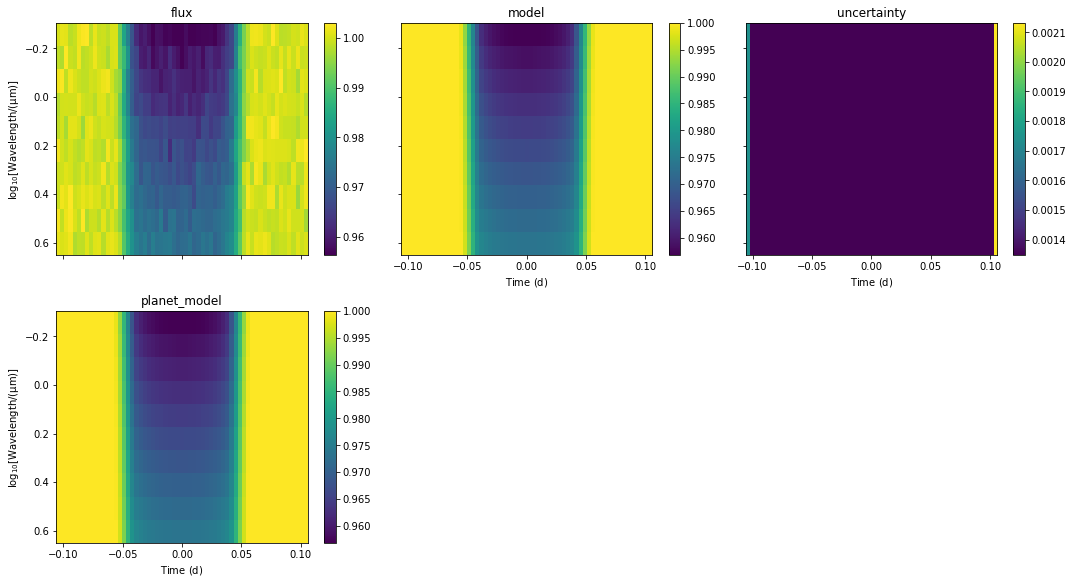

In [2]:
# create transit rainbow:
r = SimulatedRainbow(dt=1 * u.minute, R=50).inject_noise(signal_to_noise=100)

# add transit (with depth varying with wavelength):
r = r.inject_transit(
        planet_radius=np.linspace(0.2, 0.15, r.nwave),
        P=1.0,
        t0=0.0,
        baseline=1.0
    )

# bin into 10 wavelength bins:
nw = 10
rb = r.bin(nwavelengths=int(r.nwave/nw), dt=5 * u.minute)

# show the simulated dataset
rb.imshow_quantities();

In [3]:
rb

<Simulated🌈(10w, 61t)>

## Define a PyMC3 Transit Model

Now onto `chromatic_fitting`. First we need to create a transit model.

In [11]:
# create transit model:
t = TransitModel()

Then we will want to decide how our parameters will vary. We can see the parameters that we will need to provide to the model. **Warning:** if we dont set any of these parameters then they will take on default values.

In [12]:
t.required_parameters

['stellar_radius',
 'stellar_mass',
 'radius_ratio',
 'period',
 'epoch',
 'baseline',
 'impact_parameter',
 'limb_darkening']

In [13]:
t.defaults

{'stellar_radius': 1.0,
 'stellar_mass': 1.0,
 'radius_ratio': 1.0,
 'period': 1.0,
 'epoch': 0.0,
 'baseline': 1.0,
 'impact_parameter': 0.5,
 'eccentricity': 0.0,
 'omega': 0,
 'limb_darkening': [0.2, 0.2]}

Usually when we're fitting a transit we'll have some idea about the transit parameters (from previous literature or just looking at the lightcurves by eye), so it's a good idea to give good initial estimates to help our sampling converge nicely. Here we're defining the prior distributions for each parameter. There are four options for parameters in `chromatic_fitting`: `Fixed`, `WavelikeFixed`, `Fitted`, and `WavelikeFitted`. `Fixed` is one value fixed across all wavelengths, `WavelikeFixed` are fixed values that can vary between wavelengths. `Fitted` determines a prior distribution (e.g. `Uniform`, `Normal`, `TruncatedNormal`) that we will use to fit one value for the parameter across all wavelengths. Similarly, `WavelikeFitted` is a prior distribution that we will use to fit for a different value for every wavelength. 

In [14]:
# add our parameters:
t.setup_parameters(
                  period=1.0, # a fixed value!
                   epoch=Fitted(Uniform,lower=-0.05,upper=0.05), # one fitted value across all wavelengths
                   stellar_radius = Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   stellar_mass =Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   radius_ratio=WavelikeFitted(Normal, mu=0.17, sigma=0.05), # a different value fitted for every wavelength!
                   impact_parameter=Fitted(ImpactParameter,ror=0.15,testval=0.44),
                   limb_darkening=WavelikeFitted(Uniform,testval=[0.2,0.2], shape=2),
                    baseline = WavelikeFitted(Normal, mu=1.0, sigma=0.05), 
                )

# print a summary of all params:
t.summarize_parameters()

transit_stellar_radius =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='transit_stellar_radius') 🧮>

transit_stellar_mass =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='transit_stellar_mass') 🧮>

transit_radius_ratio =
  <🧮 WavelikeFitted Normal(mu=0.17, sigma=0.05, name='transit_radius_ratio') for each wavelength 🧮>

transit_period =
  <🧮 Fixed | 1.0 🧮>

transit_epoch =
  <🧮 Fitted Uniform(lower=-0.05, upper=0.05, name='transit_epoch') 🧮>

transit_baseline =
  <🧮 WavelikeFitted Normal(mu=1.0, sigma=0.05, name='transit_baseline') for each wavelength 🧮>

transit_impact_parameter =
  <🧮 Fitted ImpactParameter(ror=0.15, testval=0.44, name='transit_impact_parameter') 🧮>

transit_eccentricity =
  <🧮 Fixed | 0.0 🧮>

transit_omega =
  <🧮 Fixed | 0 🧮>

transit_limb_darkening =
  <🧮 WavelikeFitted Uniform(testval=[0.2, 0.2], shape=2, name='transit_limb_darkening') for each wavelength 🧮>



## Attach the Rainbow Object and Set-up the Model

The next step is to attach the actual data to the model and setup the lightcurves!

In [15]:
# attach the Rainbow object to the model:
t.attach_data(rb)

# this is the last point where we can change the optimization method:
t.choose_optimization_method("separate")

# setup the lightcurves for the transit model & 
# relate the "actual" data to the model (using a Normal likelihood function)
t.setup_likelihood()

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:212: UserWarning: transit in the parameter name: transit_stellar_radius. Please avoid having the model name in the parameter name as it can get confusing!
  warnings.warn(
  0%|                                                                               | 0/10 [00:00<?, ?it/s]

.setup_lightcurves() has not been run yet, running now...


 10%|███████                                                                | 1/10 [00:00<00:06,  1.47it/s]

.setup_lightcurves() has not been run yet, running now...


 20%|██████████████▏                                                        | 2/10 [00:01<00:05,  1.49it/s]

.setup_lightcurves() has not been run yet, running now...


 30%|█████████████████████▎                                                 | 3/10 [00:02<00:04,  1.49it/s]

.setup_lightcurves() has not been run yet, running now...


 40%|████████████████████████████▍                                          | 4/10 [00:02<00:04,  1.50it/s]

.setup_lightcurves() has not been run yet, running now...


 50%|███████████████████████████████████▌                                   | 5/10 [00:03<00:03,  1.50it/s]

.setup_lightcurves() has not been run yet, running now...


 60%|██████████████████████████████████████████▌                            | 6/10 [00:04<00:02,  1.50it/s]

.setup_lightcurves() has not been run yet, running now...


 70%|█████████████████████████████████████████████████▋                     | 7/10 [00:04<00:02,  1.50it/s]

.setup_lightcurves() has not been run yet, running now...


 80%|████████████████████████████████████████████████████████▊              | 8/10 [00:05<00:01,  1.49it/s]

.setup_lightcurves() has not been run yet, running now...


 90%|███████████████████████████████████████████████████████████████▉       | 9/10 [00:06<00:00,  1.50it/s]

.setup_lightcurves() has not been run yet, running now...


100%|██████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.50it/s]


If we look at our `PyMC3` model we can see that it has a lot of parameters to optimize! If we've chosen the separate wavelength fitting method (`.choose_optimization_method("separate")`) then `._pymc3_model` will return a list of PyMC3 models (one for each wavelength).

In [16]:
t._pymc3_model

We've got our transit parameters that are wavelength-independant in this case (`epoch, impact_parameter, stellar_radius, stellar_mass, a_R*, limb_darkening`) and the wavelength-dependant parameters we've defined to be `radius_ratio` and `baseline` only. The `data` parameter just represents the fit of the data to the model at each wavelength (which we've defined to be a Normal distribution). If we've set `store_models = True` at the `.setup_lightcurves()` stage then we will also see a bunch of models!

Now we can plot a couple of priors (samples from our prior distribution) - do they look OK?

100%|██████████████████████████████████████████████████████████████████████| 10/10 [00:35<00:00,  3.56s/it]


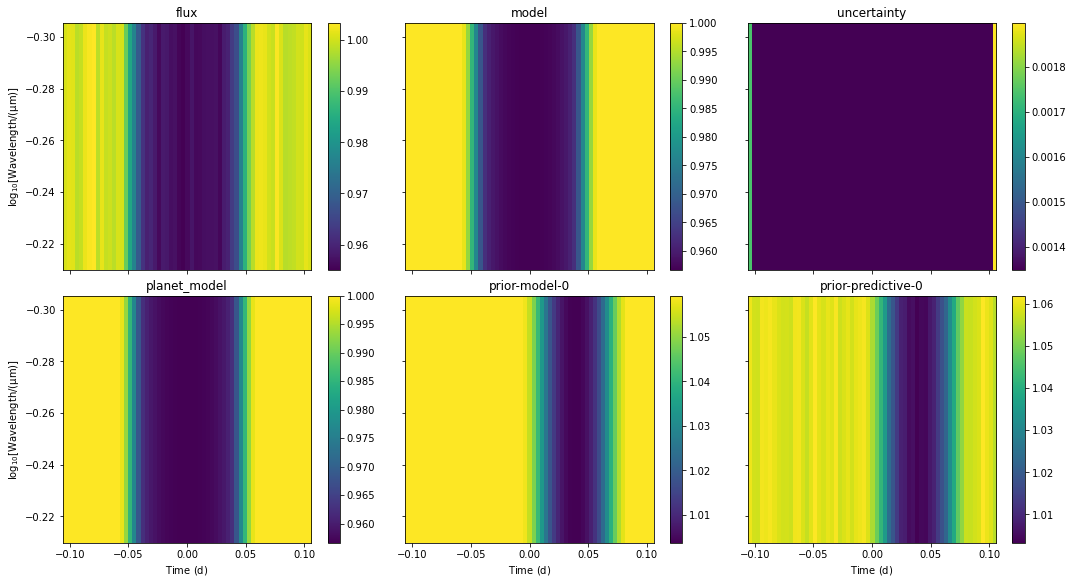

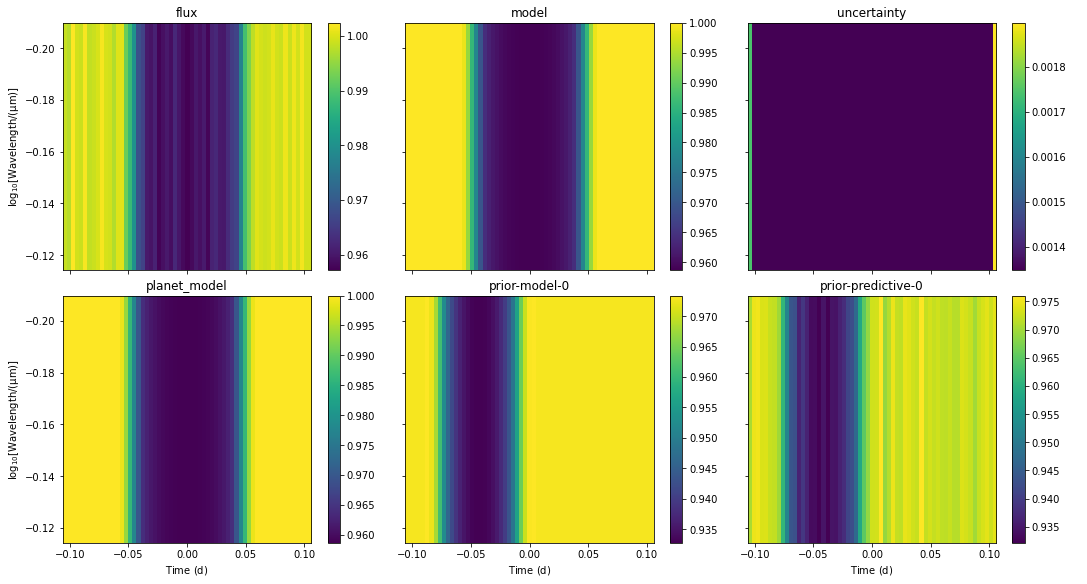

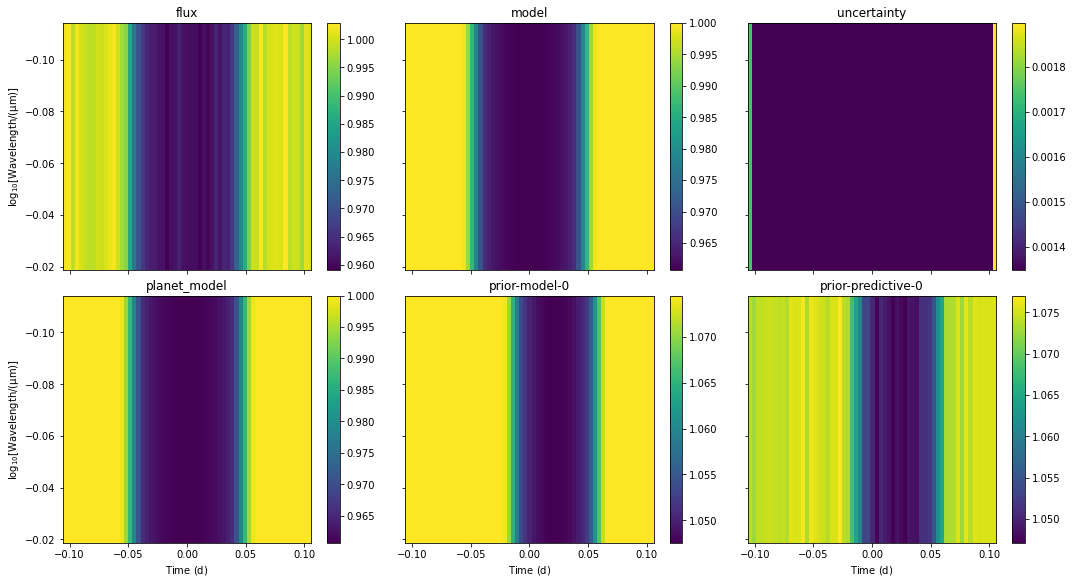

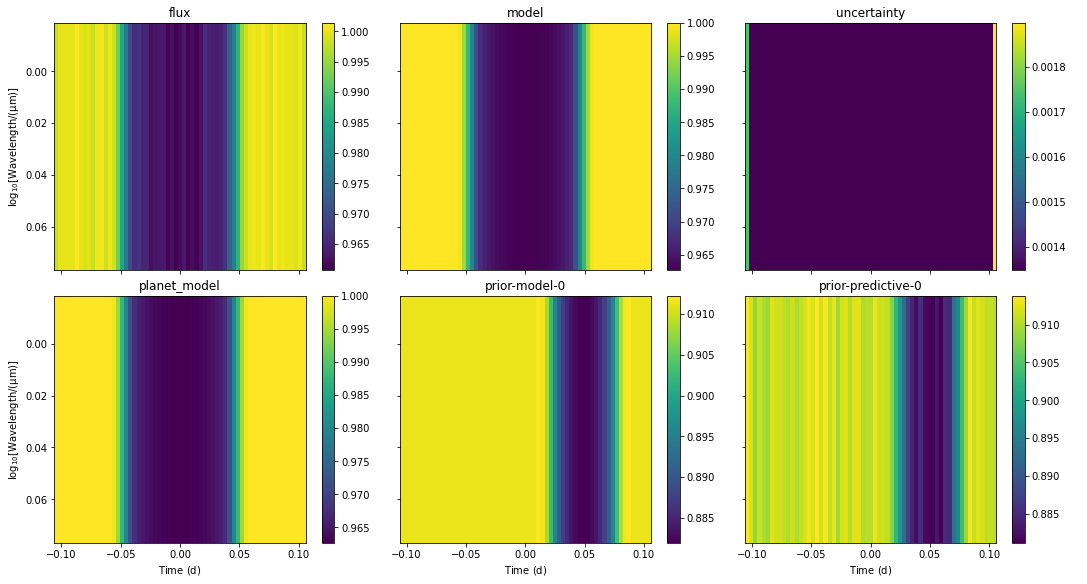

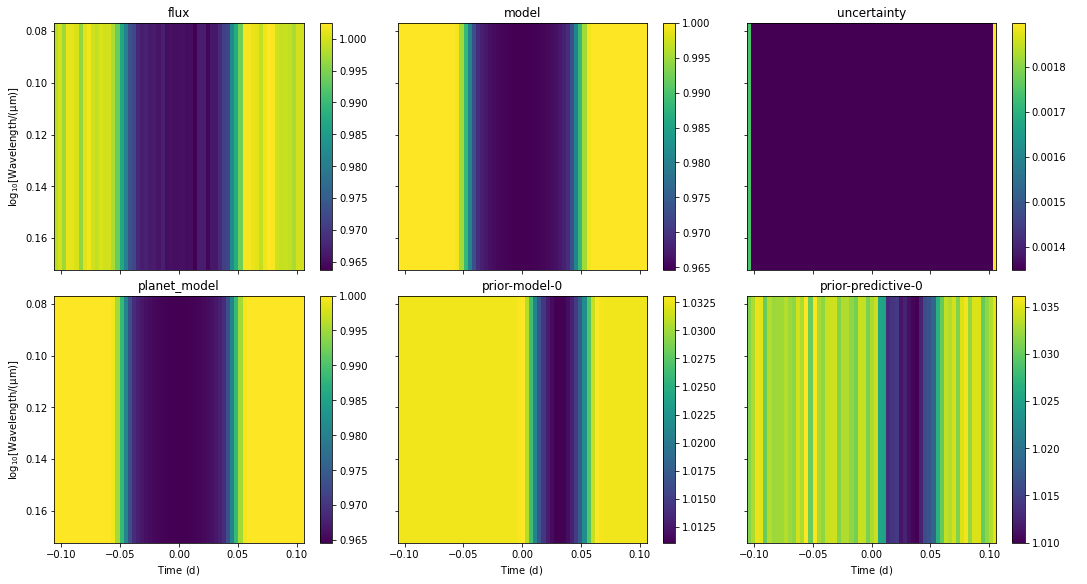

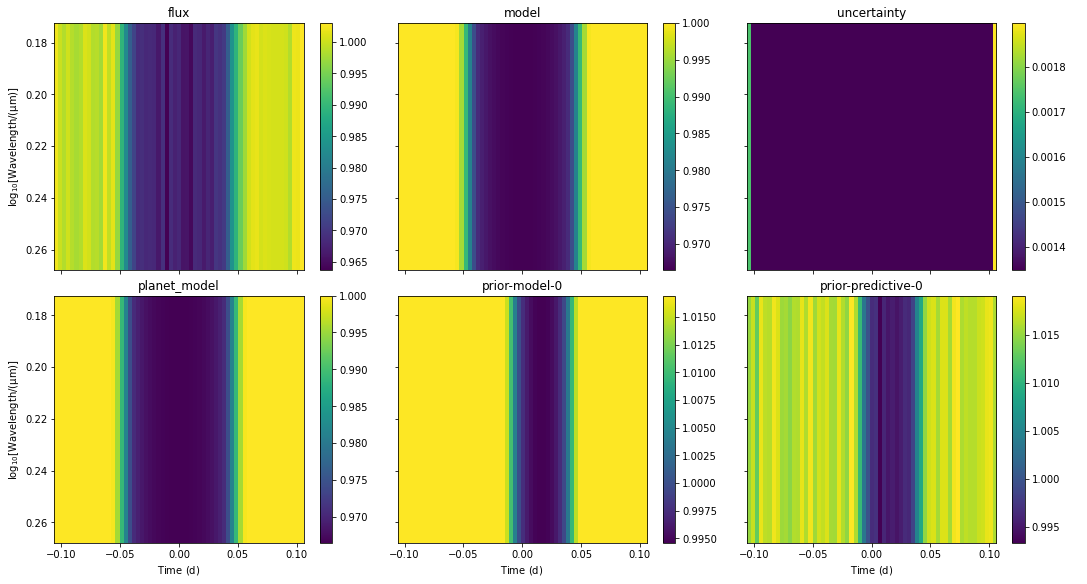

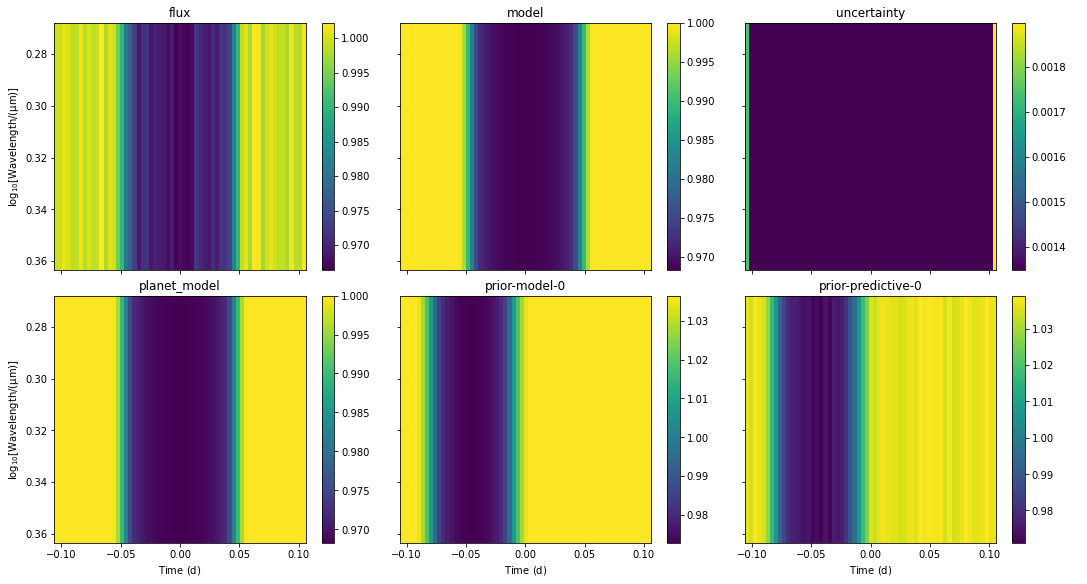

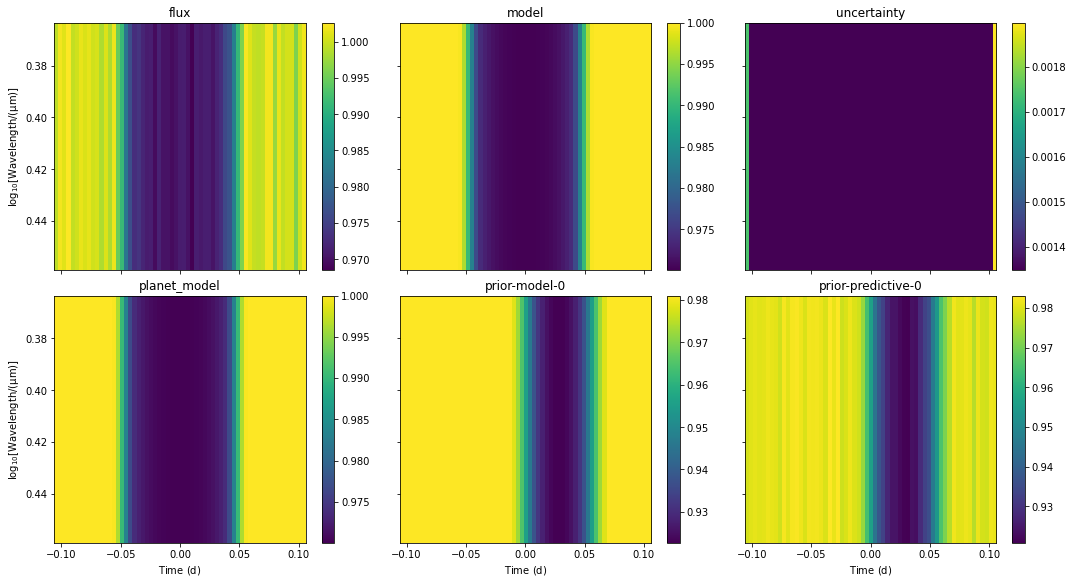

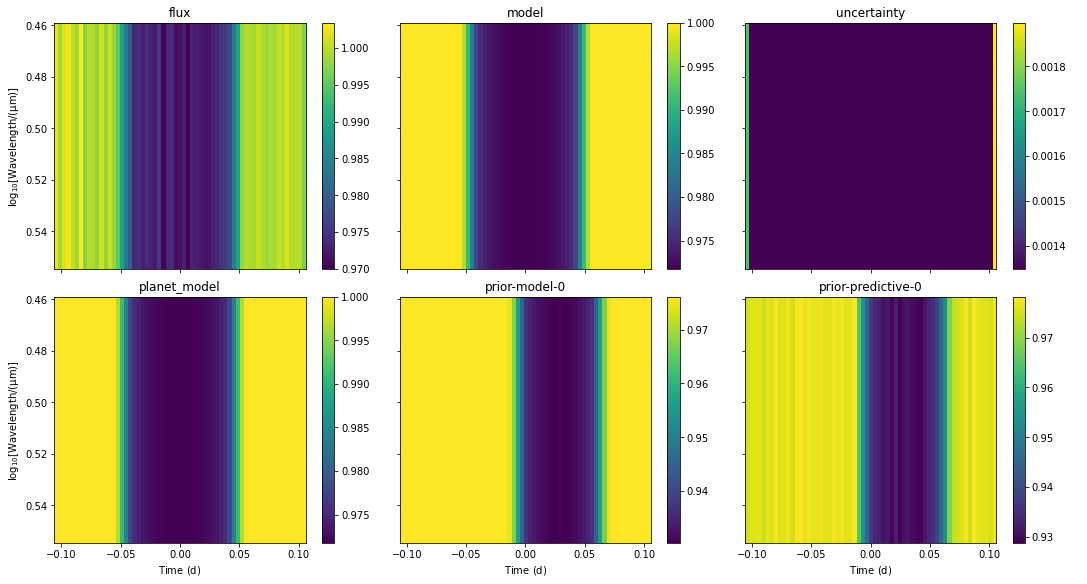

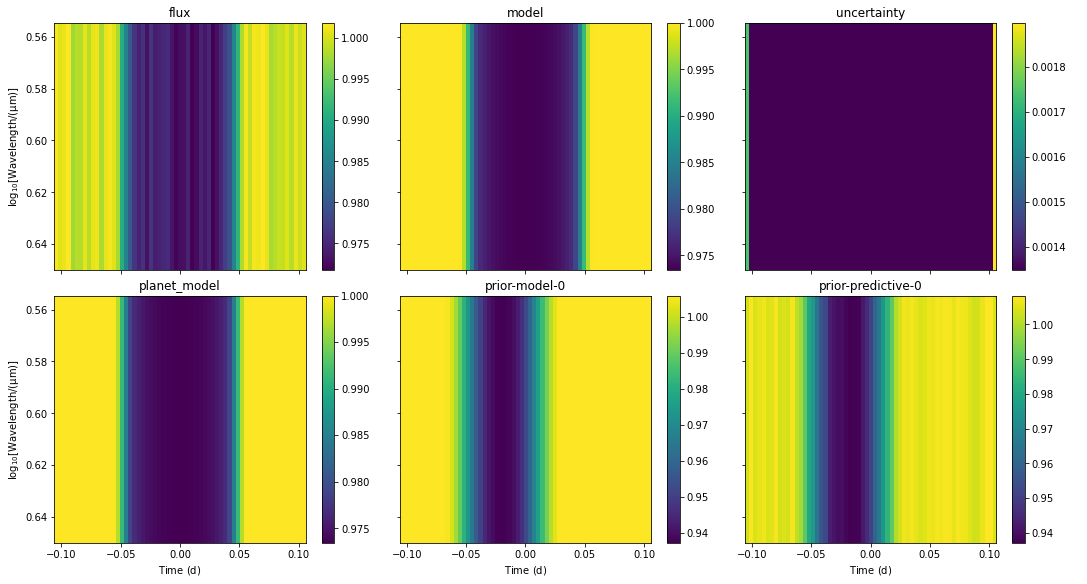

In [17]:
# t.apply_operation_to_constituent_models('plot_priors')()
t.plot_priors(n=1)

Plotting the priors can be reassuring for two reasons: (1) we're not giving priors that are vastly off from the true values, and (2) we're not over-constraining our model by giving it the exact solution and priors that are too tight.

Another check is does this planetary system actually transit given our parameters?

  0%|                                                                               | 0/10 [00:00<?, ?it/s]

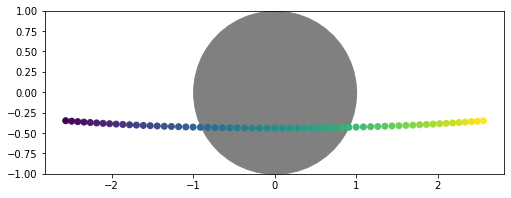

 10%|███████                                                                | 1/10 [00:00<00:03,  2.49it/s]

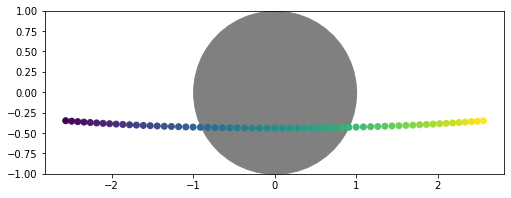

 20%|██████████████▏                                                        | 2/10 [00:00<00:02,  3.33it/s]

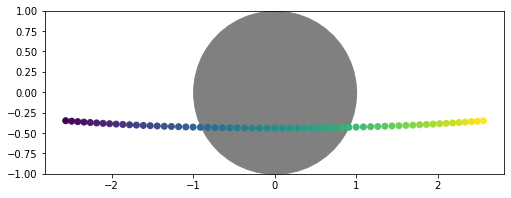

 30%|█████████████████████▎                                                 | 3/10 [00:00<00:01,  3.73it/s]

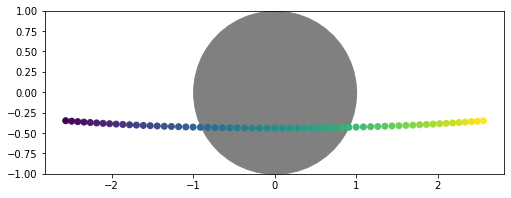

 40%|████████████████████████████▍                                          | 4/10 [00:01<00:01,  3.97it/s]

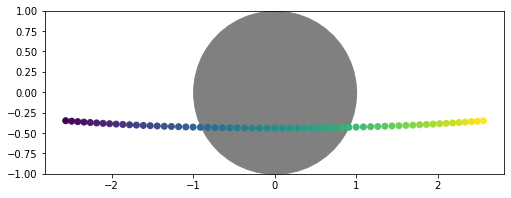

 50%|███████████████████████████████████▌                                   | 5/10 [00:01<00:01,  4.11it/s]

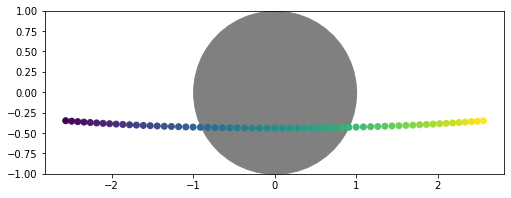

 60%|██████████████████████████████████████████▌                            | 6/10 [00:01<00:00,  4.20it/s]

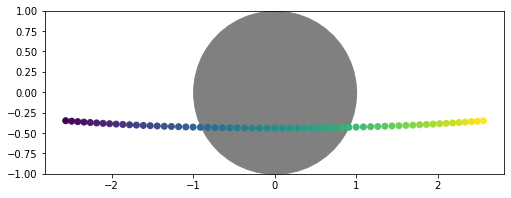

 70%|█████████████████████████████████████████████████▋                     | 7/10 [00:01<00:00,  4.26it/s]

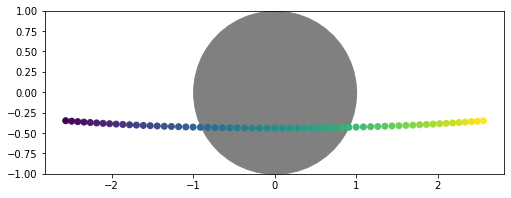

 80%|████████████████████████████████████████████████████████▊              | 8/10 [00:01<00:00,  4.31it/s]

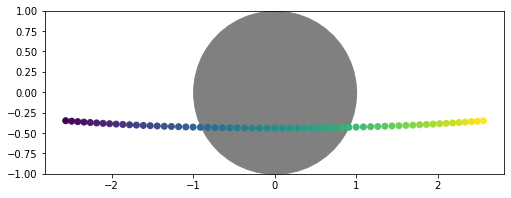

 90%|███████████████████████████████████████████████████████████████▉       | 9/10 [00:02<00:00,  4.34it/s]

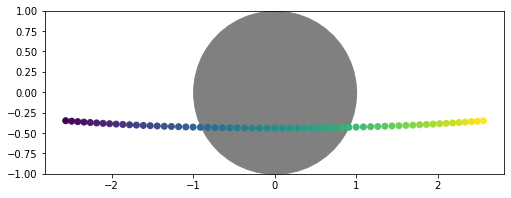

100%|██████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.08it/s]


In [18]:
t.plot_orbit()

Looks good! And a final check of what the actual lightcurves look like:

The summarize step has not been run yet. To include the 'best-fit' model please run {self}.sample() and {self}.summarize() before calling this step!


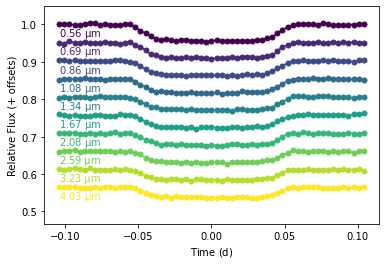

In [19]:
t.plot_lightcurves()

## PyMC3 sampling

Now we can run the NUTS sampling for our light curves (first by optimizing our initial values)

  0%|                                                                               | 0/10 [00:00<?, ?it/s]optimizing logp for variables: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


message: Desired error not necessarily achieved due to precision loss.
logp: -2867.0891083560387 -> 309.13613502484196
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:572: UserWarning: If you want to use this MAP-optimized solution as the start point in your sampling, you should run {self}.sample(use_optimized_start_point=True)!
  warnings.warn(
 10%|███████                                                                | 1/10 [00:11<01:41, 11.31s/it]optimizing logp for variables: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


message: Desired error not necessarily achieved due to precision loss.
logp: -2280.126334208701 -> 299.5052402255975


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:572: UserWarning: If you want to use this MAP-optimized solution as the start point in your sampling, you should run {self}.sample(use_optimized_start_point=True)!
  warnings.warn(
 20%|██████████████▏                                                        | 2/10 [00:14<00:54,  6.78s/it]optimizing logp for variables: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


message: Desired error not necessarily achieved due to precision loss.
logp: -1893.6035120912804 -> 310.44200991505136


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:572: UserWarning: If you want to use this MAP-optimized solution as the start point in your sampling, you should run {self}.sample(use_optimized_start_point=True)!
  warnings.warn(
 30%|█████████████████████▎                                                 | 3/10 [00:17<00:32,  4.70s/it]optimizing logp for variables: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


message: Desired error not necessarily achieved due to precision loss.
logp: -1663.231010111881 -> 320.6596460560096


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:572: UserWarning: If you want to use this MAP-optimized solution as the start point in your sampling, you should run {self}.sample(use_optimized_start_point=True)!
  warnings.warn(
 40%|████████████████████████████▍                                          | 4/10 [00:19<00:22,  3.68s/it]optimizing logp for variables: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


message: Desired error not necessarily achieved due to precision loss.
logp: -1155.2003113452613 -> 306.9960218860732


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:572: UserWarning: If you want to use this MAP-optimized solution as the start point in your sampling, you should run {self}.sample(use_optimized_start_point=True)!
  warnings.warn(
 50%|███████████████████████████████████▌                                   | 5/10 [00:21<00:15,  3.13s/it]optimizing logp for variables: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


message: Desired error not necessarily achieved due to precision loss.
logp: -913.6708417734151 -> 306.5810783422023


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:572: UserWarning: If you want to use this MAP-optimized solution as the start point in your sampling, you should run {self}.sample(use_optimized_start_point=True)!
  warnings.warn(
 60%|██████████████████████████████████████████▌                            | 6/10 [00:24<00:13,  3.27s/it]optimizing logp for variables: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


message: Desired error not necessarily achieved due to precision loss.
logp: -812.1242083536295 -> 303.0641171576559


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:572: UserWarning: If you want to use this MAP-optimized solution as the start point in your sampling, you should run {self}.sample(use_optimized_start_point=True)!
  warnings.warn(
 70%|█████████████████████████████████████████████████▋                     | 7/10 [00:27<00:08,  2.92s/it]optimizing logp for variables: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


message: Optimization terminated successfully.
logp: -625.5208118928049 -> 310.2127969407845


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:572: UserWarning: If you want to use this MAP-optimized solution as the start point in your sampling, you should run {self}.sample(use_optimized_start_point=True)!
  warnings.warn(
 80%|████████████████████████████████████████████████████████▊              | 8/10 [00:29<00:05,  2.66s/it]optimizing logp for variables: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


message: Desired error not necessarily achieved due to precision loss.
logp: -567.160177561943 -> 304.5954463758304


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:572: UserWarning: If you want to use this MAP-optimized solution as the start point in your sampling, you should run {self}.sample(use_optimized_start_point=True)!
  warnings.warn(
 90%|███████████████████████████████████████████████████████████████▉       | 9/10 [00:31<00:02,  2.49s/it]optimizing logp for variables: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


message: Optimization terminated successfully.
logp: -472.7274757989151 -> 312.93920755084406


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:572: UserWarning: If you want to use this MAP-optimized solution as the start point in your sampling, you should run {self}.sample(use_optimized_start_point=True)!
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████| 10/10 [00:34<00:00,  3.49s/it]


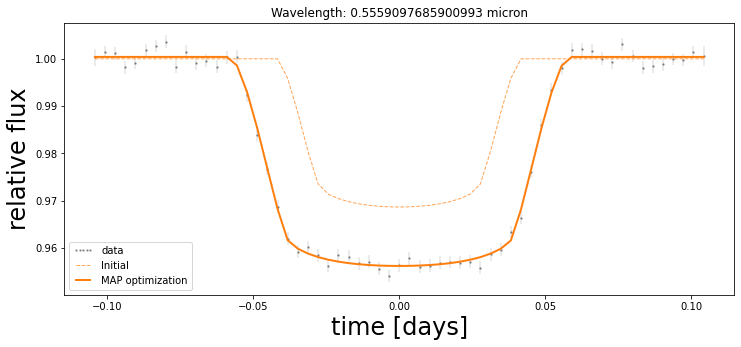

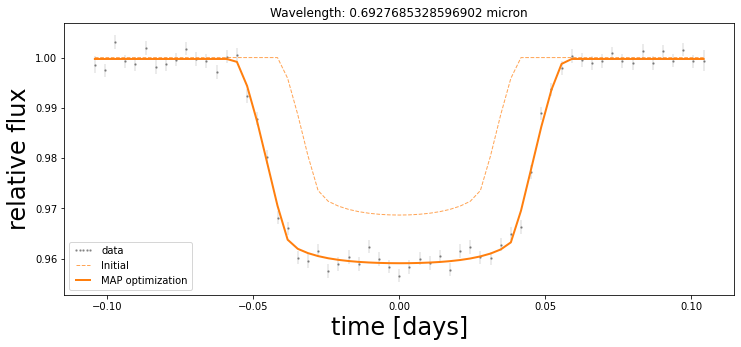

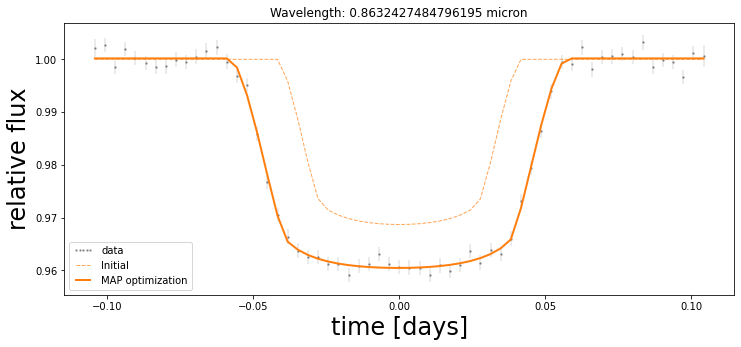

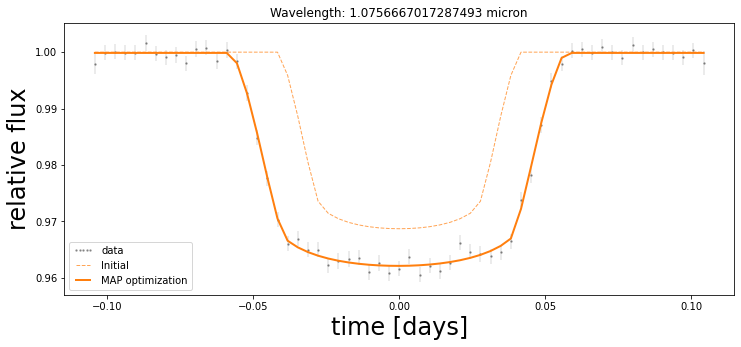

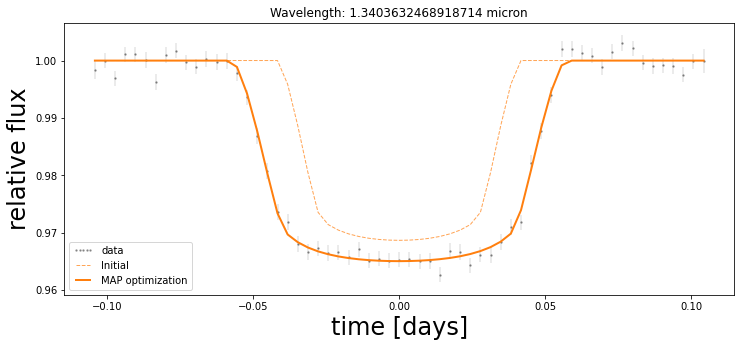

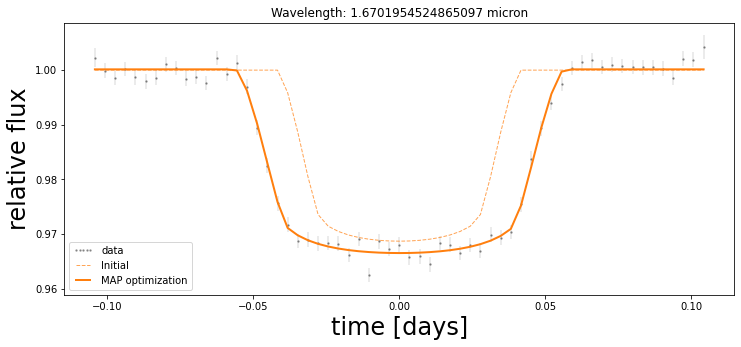

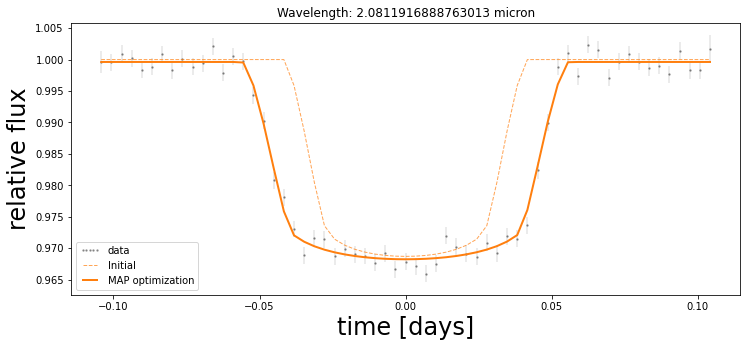

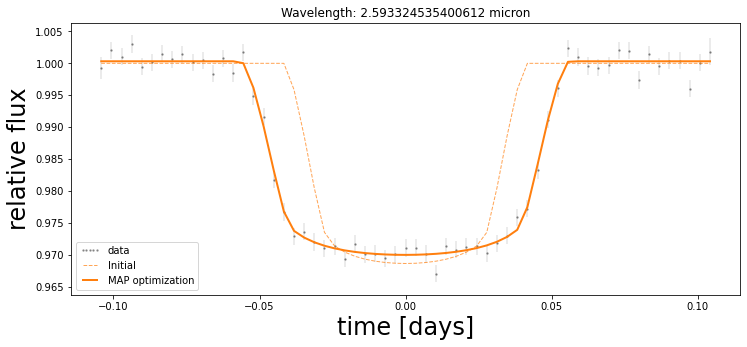

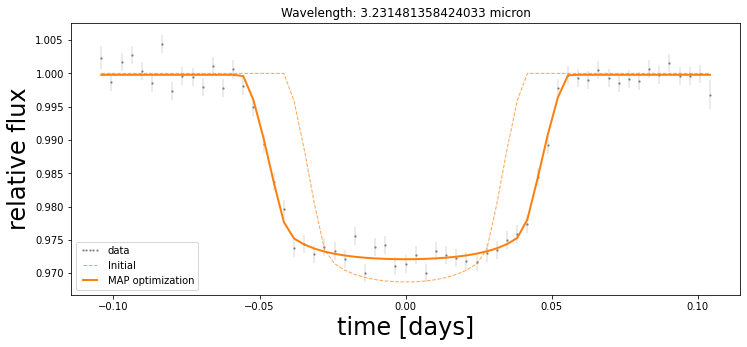

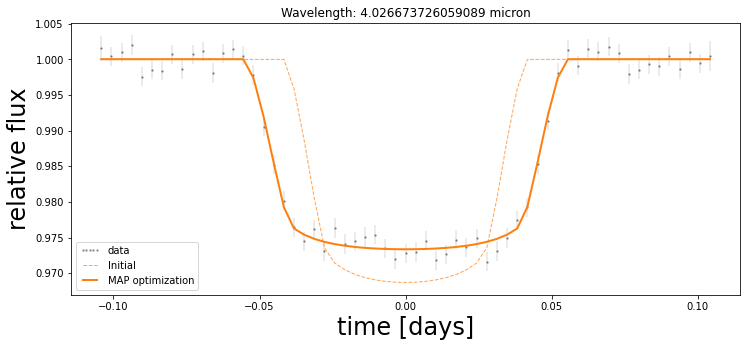

In [20]:
# optimize for initial values!
opt = t.optimize(plot=True)

In [21]:
# put those initial values into the sampling and define the number of tuning and draw steps, 
# as well as the number of chains. NOTE: if you do separate wavelength fitting then the number of steps 
# is per wavelengths, not divided between the wavelengths!
t.sample(use_optimized_start_point=True, tune=2000, draws=2000, chains=4, cores=4) #start=opt, 

  0%|                                                                               | 0/10 [00:00<?, ?it/s]

Sampling model using the <function sample at 0x288af3820> method
Using MAP-optimized start point...


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 65 seconds.
There were 62 divergences after tuning. Increase `target_accept` or reparameteri

                                  mean        sd   hdi_16%   hdi_84%  \
transit_radius_ratio[0]       0.200618  0.001985  0.198679  0.202679   
transit_baseline[0]           1.000412  0.000258  1.000185  1.000699   
transit_epoch[0]              0.000039  0.000202 -0.000143  0.000260   
transit_impact_parameter[0]   0.101589  0.068423  0.000011  0.130213   
transit_stellar_radius[0]     1.182971  0.011725  1.177669  1.199725   
transit_stellar_mass[0]       0.838556  0.026292  0.801777  0.850029   
transit_limb_darkening[0, 0]  0.136160  0.077686  0.029888  0.198915   
transit_limb_darkening[0, 1]  0.264601  0.164933  0.012527  0.344596   
transit_a_R*[0]               3.354381  0.032292  3.316625  3.384346   
transit_planet_radius[0]      0.237321  0.002955  0.234113  0.240309   

                              mcse_mean   mcse_sd     ess_bulk     ess_tail  \
transit_radius_ratio[0]        0.000087  0.000062   486.346460   250.441080   
transit_baseline[0]            0.000008  0.000005

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 56 seconds.
There were 168 divergences after tuning. Increase `target_accept` or reparameter

                                  mean        sd   hdi_16%   hdi_84%  \
transit_radius_ratio[0]       0.194072  0.001904  0.192338  0.196133   
transit_baseline[0]           0.999729  0.000257  0.999463  0.999971   
transit_epoch[0]              0.000213  0.000198 -0.000001  0.000386   
transit_impact_parameter[0]   0.100064  0.068389  0.001669  0.129381   
transit_stellar_radius[0]     1.176998  0.015179  1.170023  1.199998   
transit_stellar_mass[0]       0.857747  0.034090  0.810999  0.880905   
transit_limb_darkening[0, 0]  0.098693  0.063946  0.000035  0.129327   
transit_limb_darkening[0, 1]  0.239783  0.150629  0.015432  0.314466   
transit_a_R*[0]               3.396737  0.035599  3.363160  3.432985   
transit_planet_radius[0]      0.228418  0.003475  0.224303  0.231638   

                              mcse_mean   mcse_sd     ess_bulk     ess_tail  \
transit_radius_ratio[0]        0.000050  0.000035  1426.688129  1156.812647   
transit_baseline[0]            0.000005  0.000004

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 56 seconds.
There were 126 divergences after tuning. Increase `target_accept` or reparameter

                                  mean        sd   hdi_16%   hdi_84%  \
transit_radius_ratio[0]       0.188895  0.002041  0.186934  0.191011   
transit_baseline[0]           1.000172  0.000252  0.999916  1.000415   
transit_epoch[0]             -0.000354  0.000209 -0.000574 -0.000162   
transit_impact_parameter[0]   0.112861  0.076711  0.001330  0.148355   
transit_stellar_radius[0]     1.185890  0.010606  1.182256  1.199831   
transit_stellar_mass[0]       0.829825  0.023124  0.800051  0.838216   
transit_limb_darkening[0, 0]  0.134168  0.082638  0.003074  0.176553   
transit_limb_darkening[0, 1]  0.345444  0.183810  0.074623  0.466500   
transit_a_R*[0]               3.334582  0.034919  3.299517  3.371565   
transit_planet_radius[0]      0.224005  0.002905  0.220713  0.226809   

                              mcse_mean   mcse_sd     ess_bulk     ess_tail  \
transit_radius_ratio[0]        0.000098  0.000070   423.481853   190.463165   
transit_baseline[0]            0.000007  0.000005

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 58 seconds.
There were 55 divergences after tuning. Increase `target_accept` or reparameteri

                                  mean        sd   hdi_16%   hdi_84%  \
transit_radius_ratio[0]       0.184659  0.001639  0.183108  0.186302   
transit_baseline[0]           0.999852  0.000266  0.999617  1.000142   
transit_epoch[0]             -0.000443  0.000222 -0.000688 -0.000247   
transit_impact_parameter[0]   0.102477  0.065707  0.003656  0.135194   
transit_stellar_radius[0]     1.186407  0.009912  1.182641  1.199920   
transit_stellar_mass[0]       0.829566  0.021754  0.800014  0.837447   
transit_limb_darkening[0, 0]  0.202653  0.081983  0.138504  0.300389   
transit_limb_darkening[0, 1]  0.184011  0.145628  0.000209  0.227363   
transit_a_R*[0]               3.332771  0.030470  3.304049  3.367410   
transit_planet_radius[0]      0.219078  0.002422  0.216892  0.221845   

                              mcse_mean   mcse_sd     ess_bulk     ess_tail  \
transit_radius_ratio[0]        0.000034  0.000024  2323.449394  2301.688908   
transit_baseline[0]            0.000010  0.000007

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 54 seconds.
There were 30 divergences after tuning. Increase `target_accept` or reparameteri

                                  mean        sd   hdi_16%   hdi_84%  \
transit_radius_ratio[0]       0.176025  0.001774  0.174282  0.177810   
transit_baseline[0]           0.999997  0.000250  0.999737  1.000231   
transit_epoch[0]             -0.000154  0.000240 -0.000372  0.000104   
transit_impact_parameter[0]   0.081640  0.058194  0.001422  0.106422   
transit_stellar_radius[0]     1.187903  0.008846  1.184782  1.199996   
transit_stellar_mass[0]       0.826427  0.019439  0.800021  0.832586   
transit_limb_darkening[0, 0]  0.165947  0.097047  0.041046  0.250847   
transit_limb_darkening[0, 1]  0.346012  0.189582  0.082987  0.494390   
transit_a_R*[0]               3.324404  0.028777  3.292338  3.351917   
transit_planet_radius[0]      0.209097  0.002292  0.206691  0.211331   

                              mcse_mean   mcse_sd     ess_bulk     ess_tail  \
transit_radius_ratio[0]        0.000043  0.000030  1685.468660  1364.824857   
transit_baseline[0]            0.000005  0.000003

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 63 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameteri

                                  mean        sd   hdi_16%   hdi_84%  \
transit_radius_ratio[0]       0.173519  0.001952  0.171751  0.175581   
transit_baseline[0]           1.000146  0.000251  0.999910  1.000396   
transit_epoch[0]              0.000171  0.000253 -0.000096  0.000402   
transit_impact_parameter[0]   0.120597  0.077098  0.000146  0.160374   
transit_stellar_radius[0]     1.181750  0.013071  1.176973  1.199999   
transit_stellar_mass[0]       0.838389  0.029177  0.800311  0.848875   
transit_limb_darkening[0, 0]  0.161493  0.090545  0.052955  0.247047   
transit_limb_darkening[0, 1]  0.310932  0.191981  0.013663  0.404677   
transit_a_R*[0]               3.357619  0.039582  3.314101  3.397211   
transit_planet_radius[0]      0.205051  0.002895  0.201960  0.207997   

                              mcse_mean   mcse_sd     ess_bulk     ess_tail  \
transit_radius_ratio[0]        0.000050  0.000035  1424.738126   743.675036   
transit_baseline[0]            0.000005  0.000003

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 55 seconds.
There were 79 divergences after tuning. Increase `target_accept` or reparameteri

                                  mean        sd   hdi_16%   hdi_84%  \
transit_radius_ratio[0]       0.168758  0.001793  0.166976  0.170436   
transit_baseline[0]           0.999613  0.000253  0.999345  0.999843   
transit_epoch[0]             -0.000062  0.000249 -0.000314  0.000184   
transit_impact_parameter[0]   0.099121  0.070120  0.000262  0.126521   
transit_stellar_radius[0]     1.178676  0.014231  1.172352  1.199970   
transit_stellar_mass[0]       0.849681  0.032306  0.800297  0.864195   
transit_limb_darkening[0, 0]  0.191287  0.082869  0.119805  0.291542   
transit_limb_darkening[0, 1]  0.176289  0.145056  0.000468  0.219421   
transit_a_R*[0]               3.381285  0.036156  3.348425  3.420286   
transit_planet_radius[0]      0.198909  0.003033  0.195453  0.201681   

                              mcse_mean   mcse_sd     ess_bulk     ess_tail  \
transit_radius_ratio[0]        0.000051  0.000036  1153.783247   845.769342   
transit_baseline[0]            0.000006  0.000004

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 58 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameteri

                                  mean        sd   hdi_16%   hdi_84%  \
transit_radius_ratio[0]       0.164893  0.001857  0.163252  0.166924   
transit_baseline[0]           1.000337  0.000249  1.000078  1.000573   
transit_epoch[0]             -0.000222  0.000259 -0.000479  0.000035   
transit_impact_parameter[0]   0.091064  0.063420  0.000012  0.116404   
transit_stellar_radius[0]     1.183181  0.011900  1.178226  1.199939   
transit_stellar_mass[0]       0.838191  0.026790  0.800136  0.848704   
transit_limb_darkening[0, 0]  0.173905  0.091487  0.076503  0.274402   
transit_limb_darkening[0, 1]  0.269980  0.179983  0.000996  0.345707   
transit_a_R*[0]               3.353301  0.034063  3.317412  3.386662   
transit_planet_radius[0]      0.195094  0.002613  0.192383  0.197765   

                              mcse_mean   mcse_sd     ess_bulk     ess_tail  \
transit_radius_ratio[0]        0.000043  0.000030  1826.631811  1156.336806   
transit_baseline[0]            0.000005  0.000003

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 57 seconds.
There were 49 divergences after tuning. Increase `target_accept` or reparameteri

                                  mean        sd   hdi_16%   hdi_84%  \
transit_radius_ratio[0]       0.158353  0.001901  0.156561  0.160346   
transit_baseline[0]           0.999780  0.000251  0.999528  1.000027   
transit_epoch[0]             -0.000140  0.000288 -0.000431  0.000128   
transit_impact_parameter[0]   0.109460  0.071056  0.001326  0.143484   
transit_stellar_radius[0]     1.185174  0.011298  1.181401  1.199799   
transit_stellar_mass[0]       0.830649  0.023873  0.800032  0.838101   
transit_limb_darkening[0, 0]  0.141081  0.085697  0.000013  0.181514   
transit_limb_darkening[0, 1]  0.279768  0.178673  0.010844  0.365267   
transit_a_R*[0]               3.337715  0.037109  3.294580  3.371293   
transit_planet_radius[0]      0.187671  0.002532  0.185066  0.190193   

                              mcse_mean   mcse_sd     ess_bulk     ess_tail  \
transit_radius_ratio[0]        0.000037  0.000026  2634.999836  2465.044406   
transit_baseline[0]            0.000005  0.000003

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 55 seconds.
There were 46 divergences after tuning. Increase `target_accept` or reparameteri

                                  mean        sd   hdi_16%   hdi_84%  \
transit_radius_ratio[0]       0.156167  0.001917  0.154696  0.158473   
transit_baseline[0]           1.000027  0.000256  0.999795  1.000303   
transit_epoch[0]             -0.000012  0.000283 -0.000272  0.000292   
transit_impact_parameter[0]   0.115203  0.074483  0.000050  0.151737   
transit_stellar_radius[0]     1.179299  0.014508  1.173475  1.199993   
transit_stellar_mass[0]       0.847235  0.032292  0.800209  0.860865   
transit_limb_darkening[0, 0]  0.125011  0.079243  0.012237  0.169855   
transit_limb_darkening[0, 1]  0.265487  0.169699  0.007681  0.342662   
transit_a_R*[0]               3.376303  0.039872  3.334107  3.416084   
transit_planet_radius[0]      0.184163  0.002930  0.181097  0.187188   

                              mcse_mean   mcse_sd     ess_bulk     ess_tail  \
transit_radius_ratio[0]        0.000041  0.000029  2125.408137  2207.824219   
transit_baseline[0]            0.000005  0.000004

100%|██████████████████████████████████████████████████████████████████████| 10/10 [00:31<00:00,  3.15s/it]


At this stage the sampler may print out some warnings that we don't have enough tuning steps! Also be aware this step can be quite slow depending on how many parameters we're trying to fit at once (which may increase with the number of wavelengths). We can then see the results of our sampling by running `.summarize()`:

In [22]:
t.summary

,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
transit_radius_ratio[0],0.200618,0.001985,0.198679,0.202679,0.000087,0.000062,486.346460,250.441080,1.005613
transit_baseline[0],1.000412,0.000258,1.000185,1.000699,0.000008,0.000005,1090.209736,1745.026501,1.004197
transit_epoch[0],0.000039,0.000202,-0.000143,0.000260,0.000006,0.000004,1105.357078,1689.229491,1.003048
transit_impact_parameter[0],0.101589,0.068423,0.000011,0.130213,0.003426,0.002926,422.540100,217.561354,1.008601
transit_stellar_radius[0],1.182971,0.011725,1.177669,1.199725,0.000398,0.000282,743.915927,984.097823,1.004714
...,...,...,...,...,...,...,...,...,...
transit_stellar_mass[9],0.847235,0.032292,0.800209,0.860865,0.000855,0.000605,1073.278889,673.041085,1.000960
"transit_limb_darkening[9, 0]",0.125011,0.079243,0.012237,0.169855,0.001846,0.001306,1669.600563,1488.291529,1.002195
"transit_limb_darkening[9, 1]",0.265487,0.169699,0.007681,0.342662,0.004124,0.002917,1207.858634,649.705462,1.003673
transit_a_R*[9],3.376303,0.039872,3.334107,3.416084,0.000924,0.000654,1865.023878,1956.969707,1.002125


An important parameter to look out for here to check whether your samplings have converged is [`r_hat`](https://arviz-devs.github.io/arviz/api/generated/arviz.rhat.html#arviz.rhat). This [rank normalized R-hat diagnostic](https://arxiv.org/abs/1903.08008) tests for lack of convergence by comparing the variance between multiple chains to the variance within each chain. If convergence has been achieved, the between-chain and within-chain variances should be identicalm therefore, the closer it is to 1 the better the chance that your sampling successfully converged. If you're interested in the sampling see the [`PyMC3 docs`](https://docs.pymc.io/en/v3/index.html) for much more detail!

In [23]:
np.all(t.summary['r_hat'].values < 1.05) # check the convergence is good!

True

We might also want to see a couple of posterior samples as a "quick-look" check! **But beware** if you've chosen the "separate" optimization method then it will plot the posteriors for every wavelength!):

  0%|                                                                               | 0/10 [00:00<?, ?it/s]/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


 10%|███████                                                                | 1/10 [00:02<00:25,  2.89s/it]

 20%|██████████████▏                                                        | 2/10 [00:06<00:28,  3.56s/it]

 30%|█████████████████████▎                                                 | 3/10 [00:10<00:26,  3.77s/it]

 40%|████████████████████████████▍                                          | 4/10 [00:13<00:20,  3.43s/it]

 50%|███████████████████████████████████▌                                   | 5/10 [00:18<00:18,  3.71s/it]

 60%|██████████████████████████████████████████▌                            | 6/10 [00:21<00:13,  3.45s/it]

 70%|█████████████████████████████████████████████████▋                     | 7/10 [00:25<00:11,  3.69s/it]

 80%|████████████████████████████████████████████████████████▊              | 8/10 [00:29<00:07,  3.85s/it]

 90%|███████████████████████████████████████████████████████████████▉       | 9/10 [00:32<00:03,  3.58s/it]

100%|██████████████████████████████████████████████████████████████████████| 10/10 [00:36<00:00,  3.66s/it]


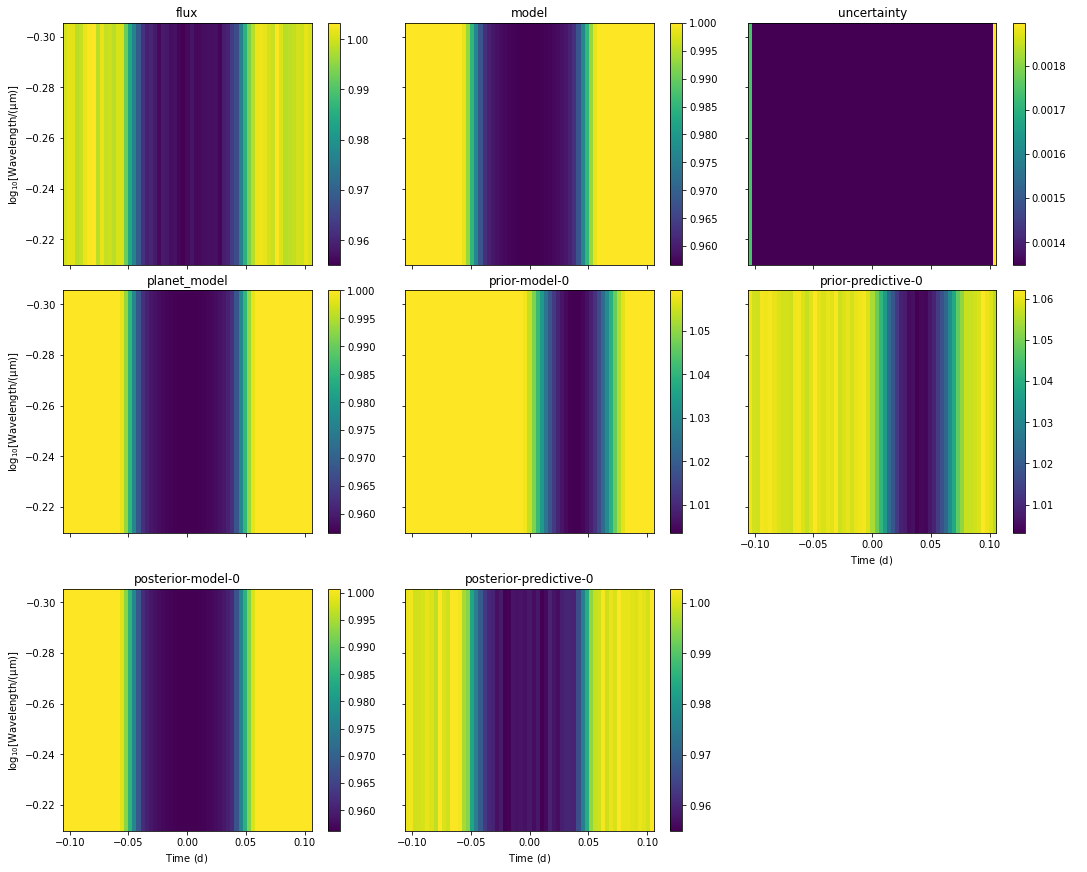

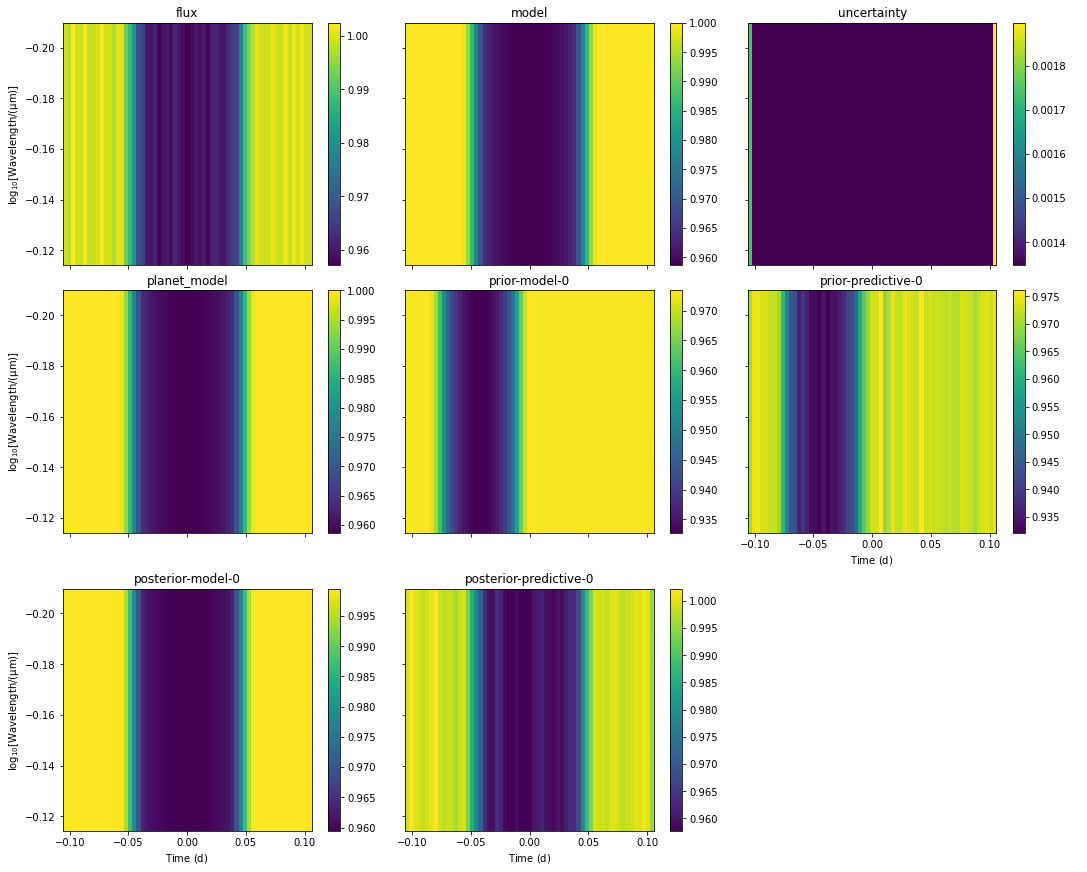

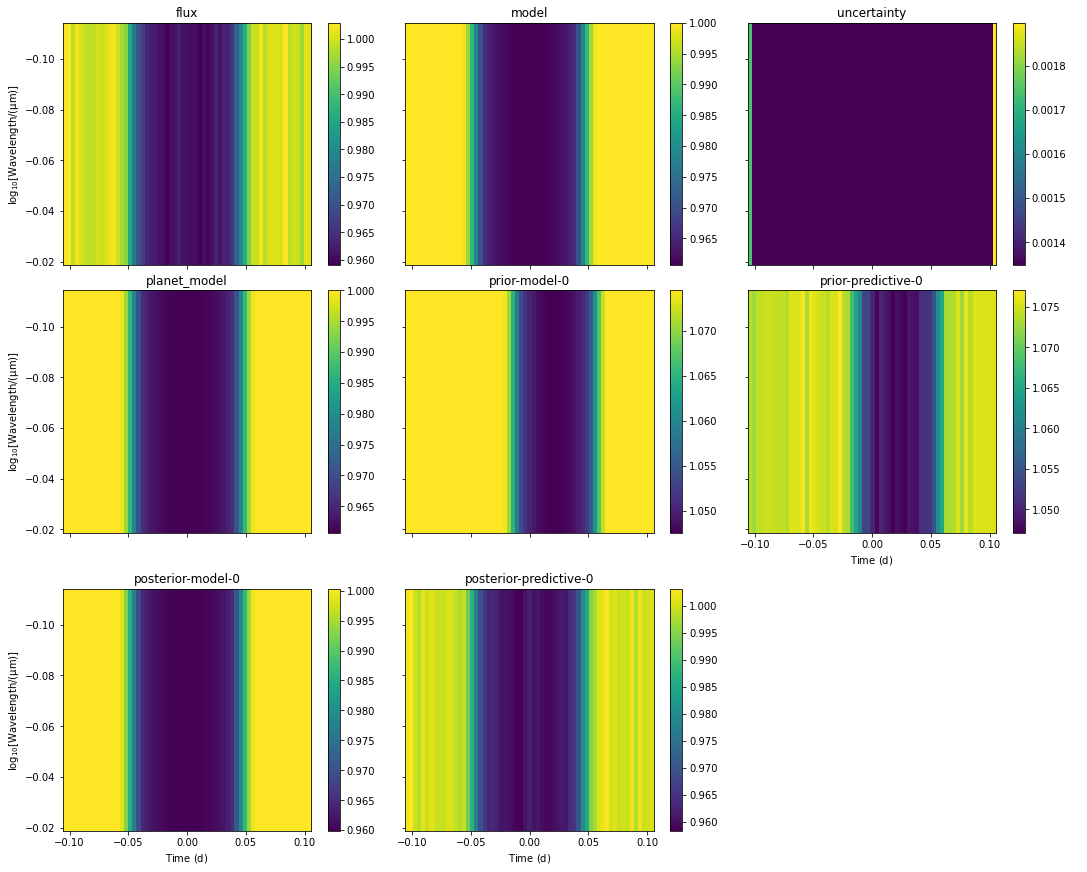

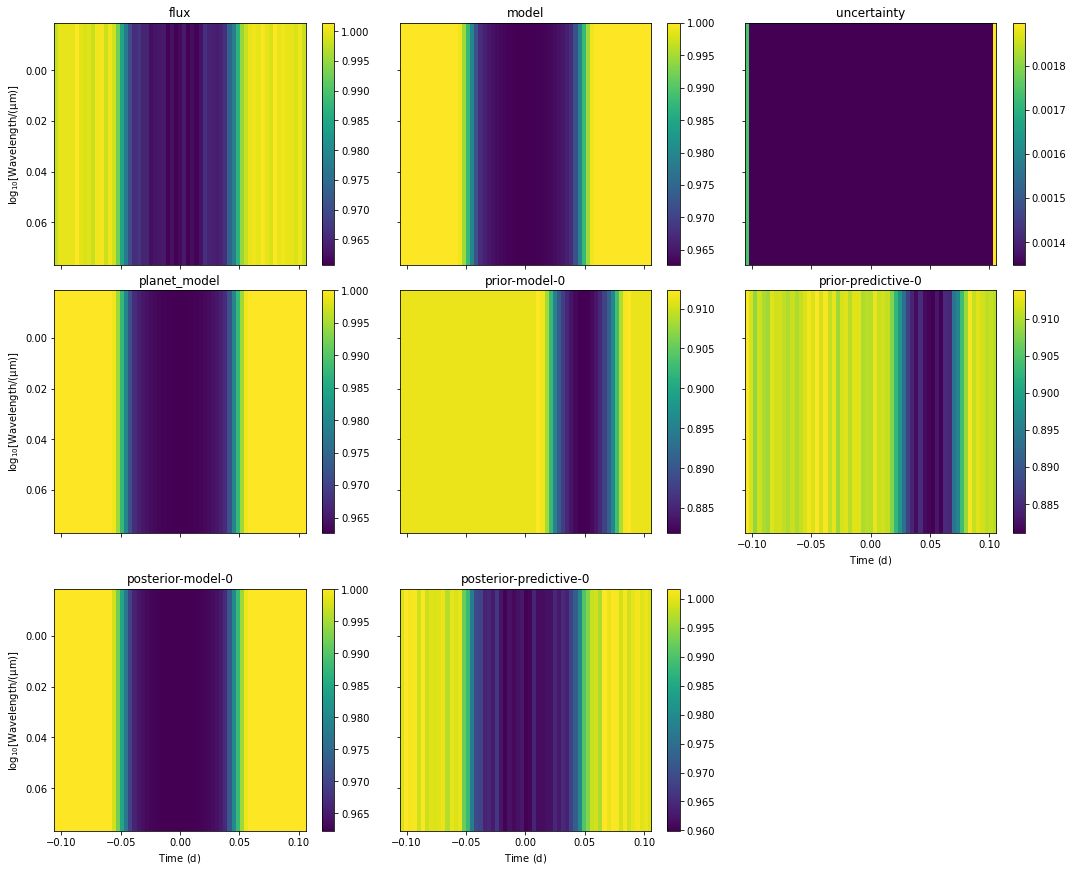

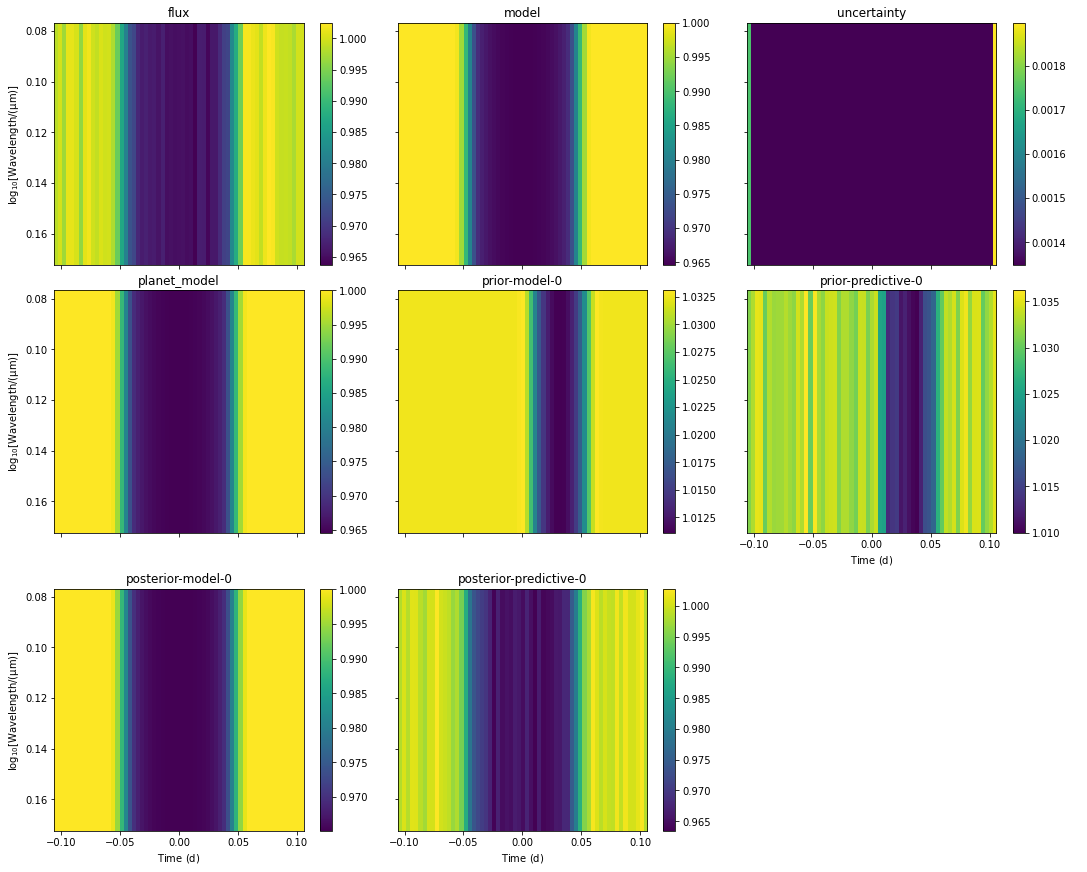

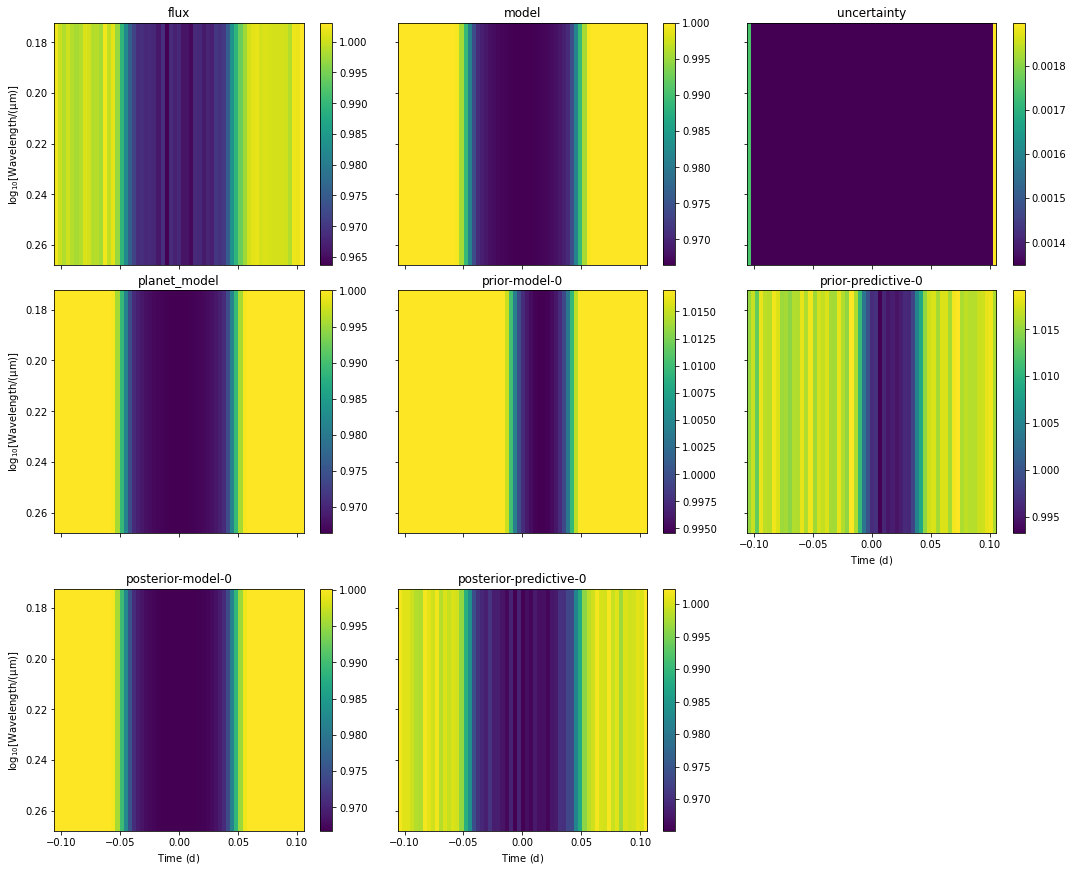

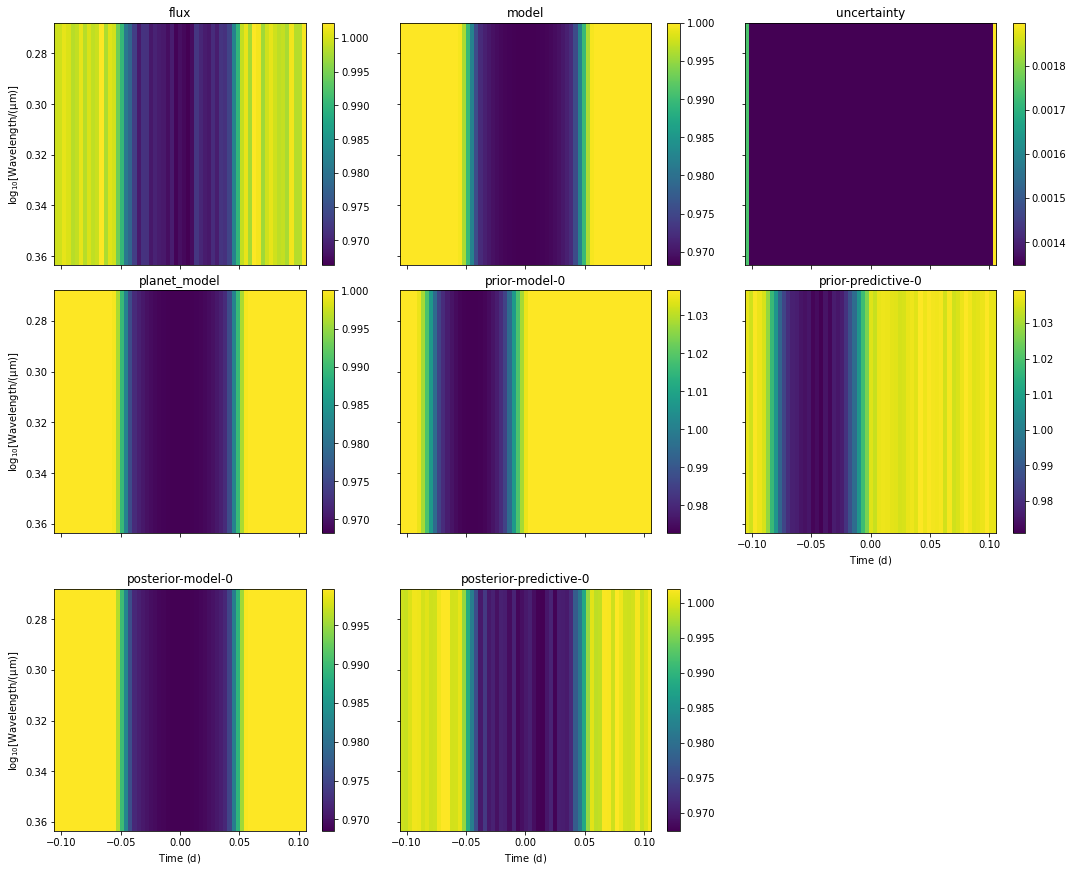

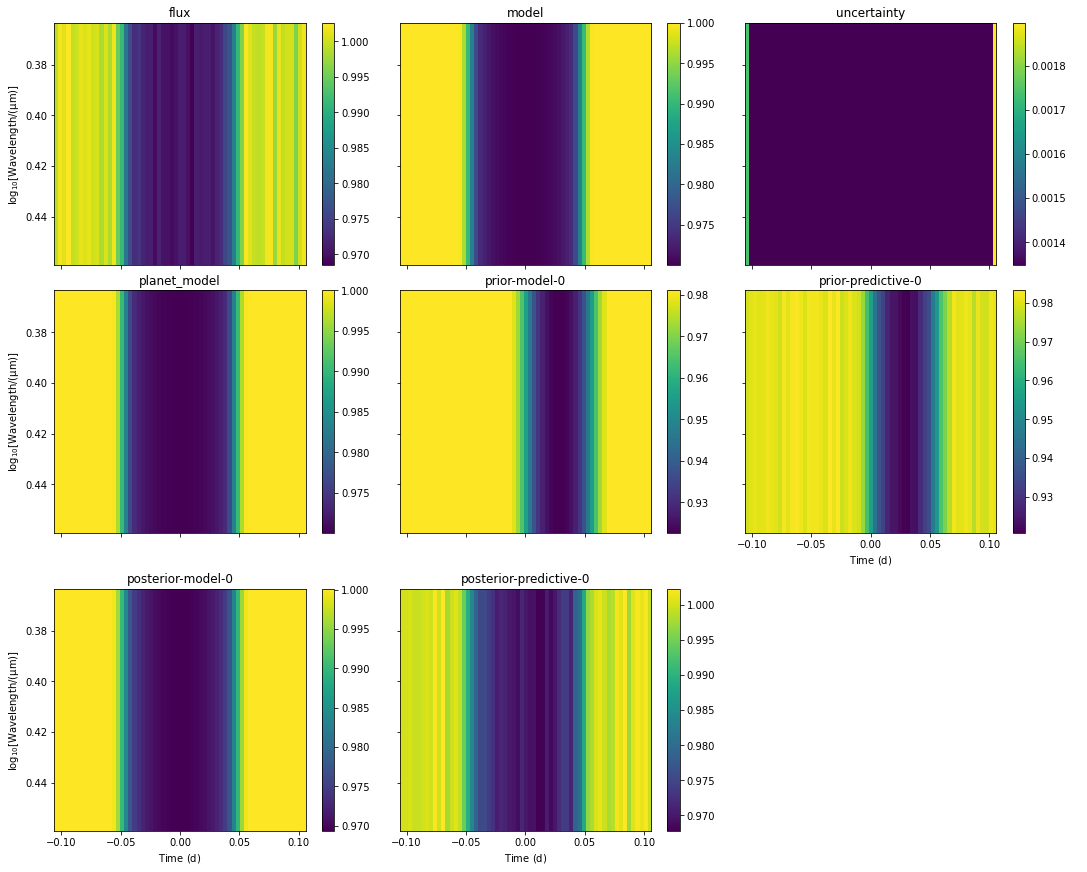

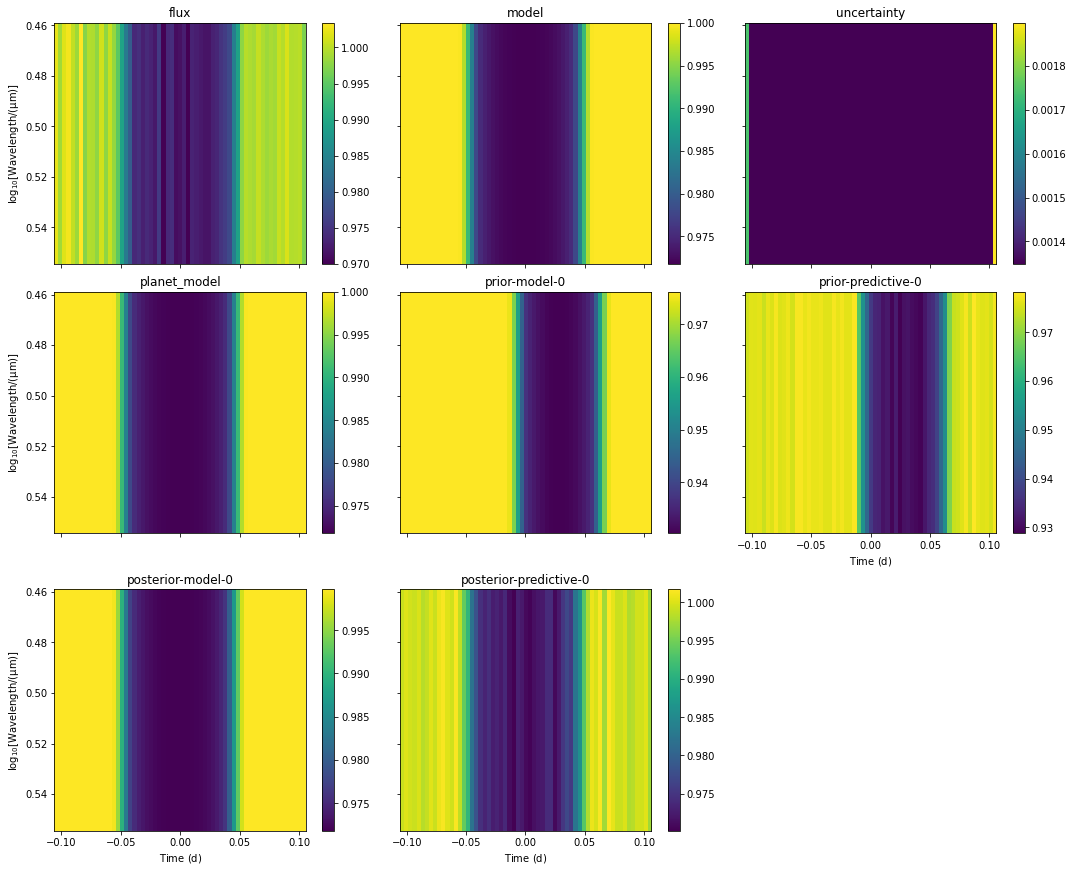

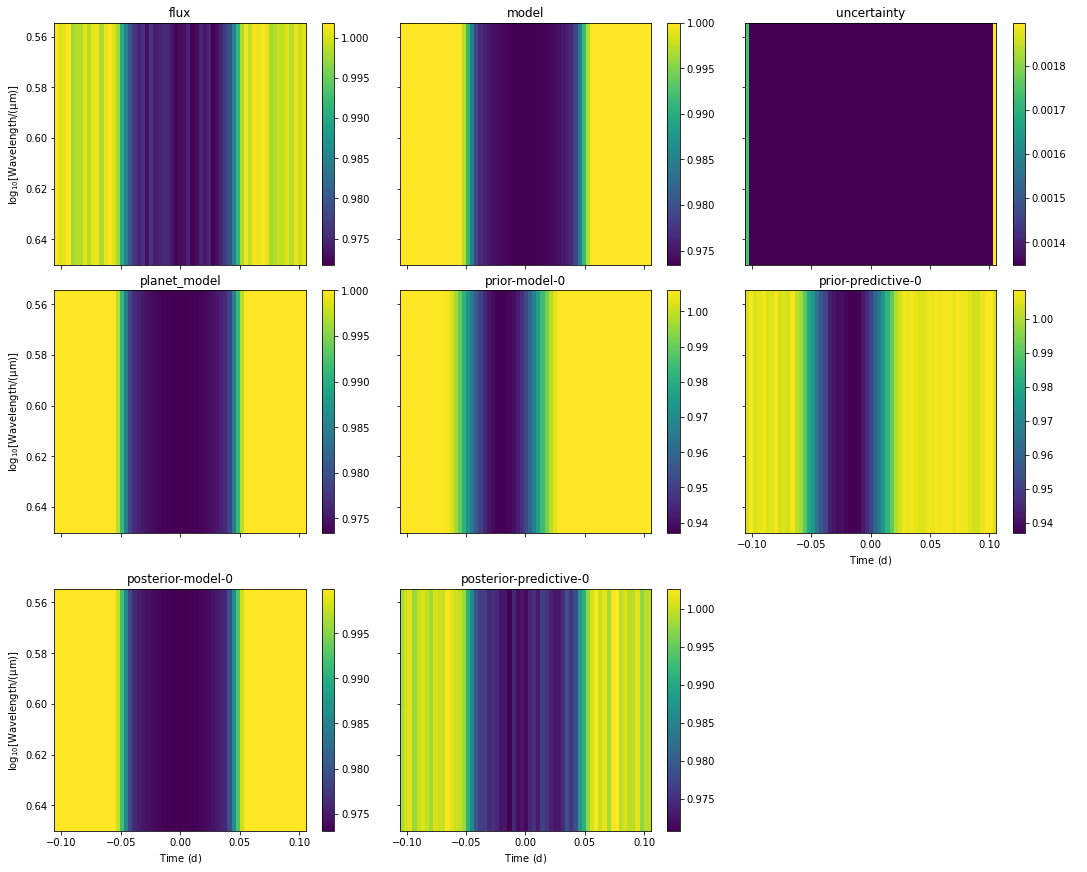

In [24]:
t.plot_posteriors(n=1)

But what are the results?? We can easily see the results using the handy `.get_results()` function:

In [25]:
t.parameters['transit_a_R*'] = []
results = t.get_results(uncertainty='sd')#['hdi_16%','hdi_84%'])

# results is a pandas dataframe, however, it doesn't show up properly on Git docs so I'll convert it to an
# astropy table
from astropy.table import Table
Table.from_pandas(results)

transit_baseline,transit_baseline_hdi_16%,transit_baseline_hdi_84%,transit_eccentricity,transit_eccentricity_hdi_16%,transit_eccentricity_hdi_84%,transit_epoch,transit_epoch_hdi_16%,transit_epoch_hdi_84%,transit_impact_parameter,transit_impact_parameter_hdi_16%,transit_impact_parameter_hdi_84%,transit_limb_darkening,transit_limb_darkening_hdi_16%,transit_limb_darkening_hdi_84%,transit_omega,transit_omega_hdi_16%,transit_omega_hdi_84%,transit_period,transit_period_hdi_16%,transit_period_hdi_84%,transit_radius_ratio,transit_radius_ratio_hdi_16%,transit_radius_ratio_hdi_84%,transit_stellar_mass,transit_stellar_mass_hdi_16%,transit_stellar_mass_hdi_84%,transit_stellar_radius,transit_stellar_radius_hdi_16%,transit_stellar_radius_hdi_84%,wavelength
object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
1.0004125,1.000185,1.0006988,0.0,0.0,0.0,3.9e-05,-0.0001435,0.00026,0.1015889,1.11e-05,0.1302126,"[0.1361599, 0.2646012]","[0.0298878, 0.0125268]","[0.1989154, 0.3445961]",0,0,0,1.0,1.0,1.0,0.2006182,0.1986791,0.2026792,0.838556,0.8017767,0.8500294,1.182971,1.1776689,1.1997246,0.5559097685900993 micron
0.9997287,0.9994629,0.9999714,0.0,0.0,0.0,0.0002126,-1.4e-06,0.0003858,0.1000637,0.0016687,0.1293806,"[0.0986929, 0.2397832]","[3.5e-05, 0.0154321]","[0.1293272, 0.3144656]",0,0,0,1.0,1.0,1.0,0.1940715,0.192338,0.1961331,0.857747,0.810999,0.8809048,1.1769983,1.1700231,1.1999982,0.6927685328596902 micron
1.0001721,0.9999164,1.0004149,0.0,0.0,0.0,-0.0003536,-0.0005742,-0.0001616,0.1128605,0.0013298,0.1483545,"[0.1341684, 0.3454436]","[0.0030739, 0.0746233]","[0.1765527, 0.4665003]",0,0,0,1.0,1.0,1.0,0.1888948,0.1869338,0.1910109,0.829825,0.8000514,0.8382155,1.1858903,1.1822559,1.1998314,0.8632427484796195 micron
0.9998523,0.9996174,1.0001415,0.0,0.0,0.0,-0.0004429,-0.0006878,-0.0002475,0.1024774,0.0036564,0.1351938,"[0.2026529, 0.1840113]","[0.138504, 0.0002091]","[0.300389, 0.2273634]",0,0,0,1.0,1.0,1.0,0.1846589,0.1831082,0.1863021,0.8295663,0.8000143,0.8374472,1.1864066,1.1826409,1.1999201,1.0756667017287493 micron
0.9999973,0.9997371,1.0002309,0.0,0.0,0.0,-0.0001543,-0.0003722,0.0001039,0.0816398,0.0014224,0.1064216,"[0.1659475, 0.3460117]","[0.0410459, 0.082987]","[0.2508469, 0.49439]",0,0,0,1.0,1.0,1.0,0.1760253,0.1742823,0.1778104,0.8264272,0.800021,0.8325858,1.1879032,1.1847817,1.1999962,1.3403632468918714 micron
1.0001464,0.9999098,1.0003961,0.0,0.0,0.0,0.0001712,-9.61e-05,0.0004018,0.1205971,0.0001464,0.160374,"[0.1614931, 0.3109318]","[0.0529552, 0.0136631]","[0.2470468, 0.404677]",0,0,0,1.0,1.0,1.0,0.1735187,0.1717514,0.1755808,0.8383893,0.8003107,0.8488747,1.1817505,1.1769732,1.1999992,1.6701954524865097 micron
0.9996134,0.9993451,0.9998426,0.0,0.0,0.0,-6.2e-05,-0.0003141,0.0001836,0.0991212,0.0002617,0.1265212,"[0.191287, 0.1762892]","[0.1198051, 0.0004677]","[0.2915421, 0.219421]",0,0,0,1.0,1.0,1.0,0.1687583,0.1669764,0.1704364,0.8496815,0.8002969,0.8641954,1.1786765,1.172352,1.1999699,2.0811916888763013 micron
1.0003371,1.0000783,1.0005729,0.0,0.0,0.0,-0.0002222,-0.0004788,3.47e-05,0.0910642,1.17e-05,0.1164038,"[0.1739055, 0.2699799]","[0.0765033, 0.0009964]","[0.2744025, 0.3457071]",0,0,0,1.0,1.0,1.0,0.1648931,0.1632517,0.1669238,0.8381909,0.8001363,0.848704,1.1831809,1.1782256,1.1999385,2.593324535400612 micron
0.9997799,0.9995283,1.0000269,0.0,0.0,0.0,-0.0001397,-0.000431,0.0001281,0.1094603,0.0013259,0.1434836,"[0.141081, 0.2797679]","[1.32e-05, 0.0108444]","[0.1815141, 0.3652672]",0,0,0,1.0,1.0,1.0,0.158353,0.1565609,0.1603456,0.8306489,0.800032,0.8381013,1.1851743,1.1814006,1.1997993,3.231481358424033 micron


We can also make a transmission spectrum table using `.make_transmission_spectrum_table() `

In [26]:
transmission_spectrum = t.make_transmission_spectrum_table(uncertainty=['hdi_16%','hdi_84%'])

Table.from_pandas(transmission_spectrum)

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/transit.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans_table[f"{self.name}_radius_ratio_neg_error"] = (


wavelength,transit_radius_ratio,transit_radius_ratio_neg_error,transit_radius_ratio_pos_error
object,object,object,object
0.5559097685900993 micron,0.2006182,0.0019390999999999992,0.0020610000000000073
0.6927685328596902 micron,0.1940715,0.001733499999999999,0.0020615999999999968
0.8632427484796195 micron,0.1888948,0.0019609999999999905,0.0021161000000000096
1.0756667017287493 micron,0.1846589,0.0015506999999999882,0.0016432000000000113
1.3403632468918714 micron,0.1760253,0.0017429999999999946,0.0017851000000000117
1.6701954524865097 micron,0.1735187,0.0017672999999999994,0.002062100000000011
2.0811916888763013 micron,0.1687583,0.001781900000000003,0.001678099999999988
2.593324535400612 micron,0.1648931,0.0016413999999999873,0.002030700000000024
3.231481358424033 micron,0.158353,0.001792099999999991,0.001992600000000011


We can also create (or call if you set `store_models=True`) the final best-fit models using the `.get_models()` function. This can take a minute if generating the models from parameters for lots of wavelengths.

In [27]:
models = t.get_model()
models.keys()

dict_keys(['w0', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9'])

As the `.get_model()` process can take time to generate the models, we store the models for use later...

In [28]:
t._fit_models.keys()

dict_keys(['w0', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9'])

## Visualizing Results

We have several different methods (mostly wrappers to `chromatic` functions) to plot the modelled results. I'll demonstrate several of them below:

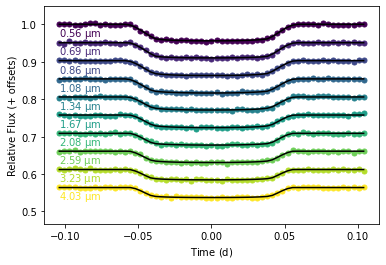

In [29]:
t.plot_lightcurves()

100%|██████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.80it/s]


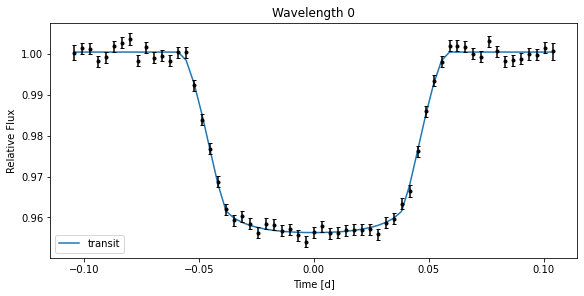

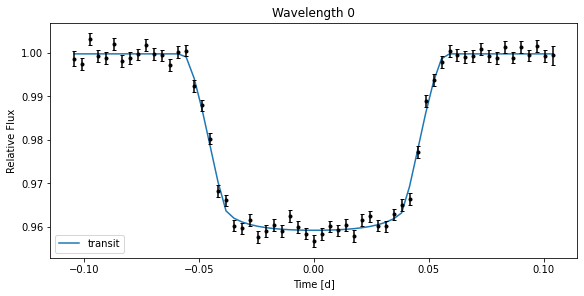

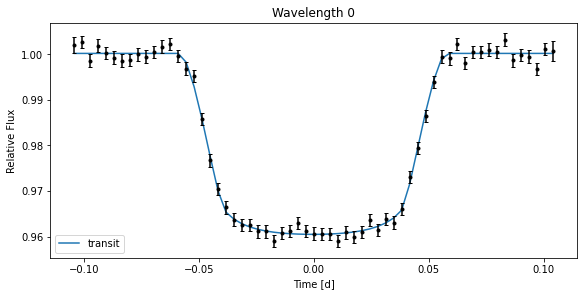

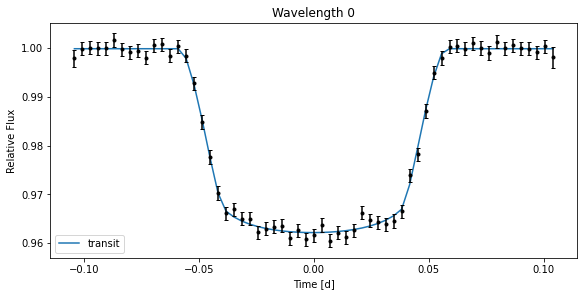

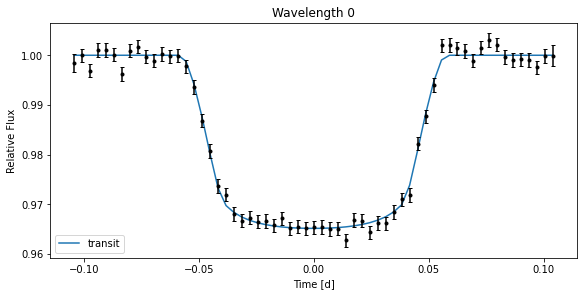

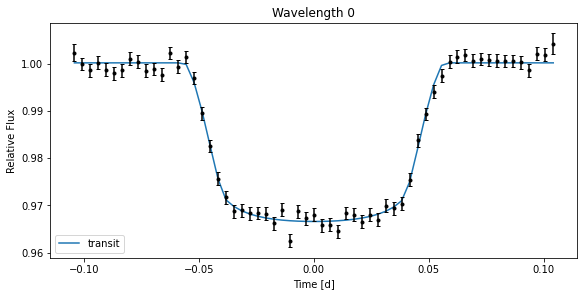

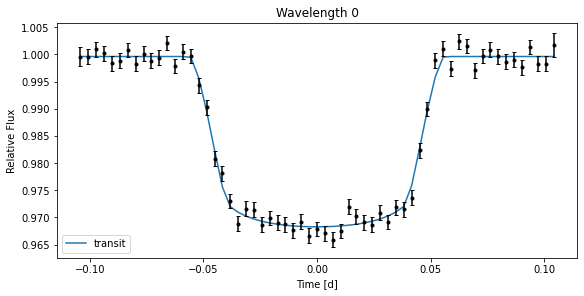

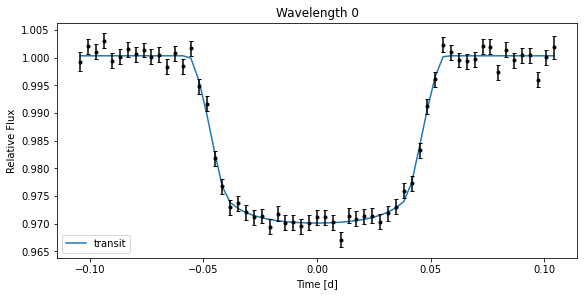

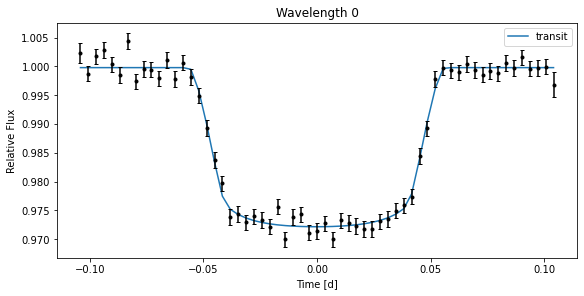

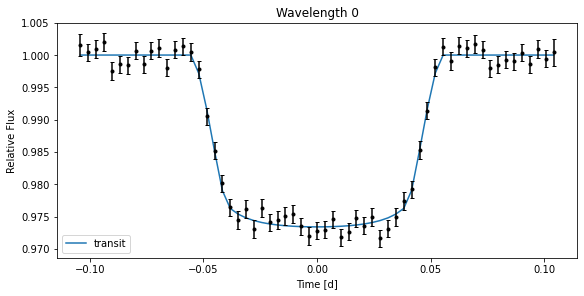

In [30]:
t.plot_model()

## Check Residuals

No model attached to data. Running `add_model_to_rainbow` now. You can access this data later using [self].data_with_model


100%|██████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.05it/s]


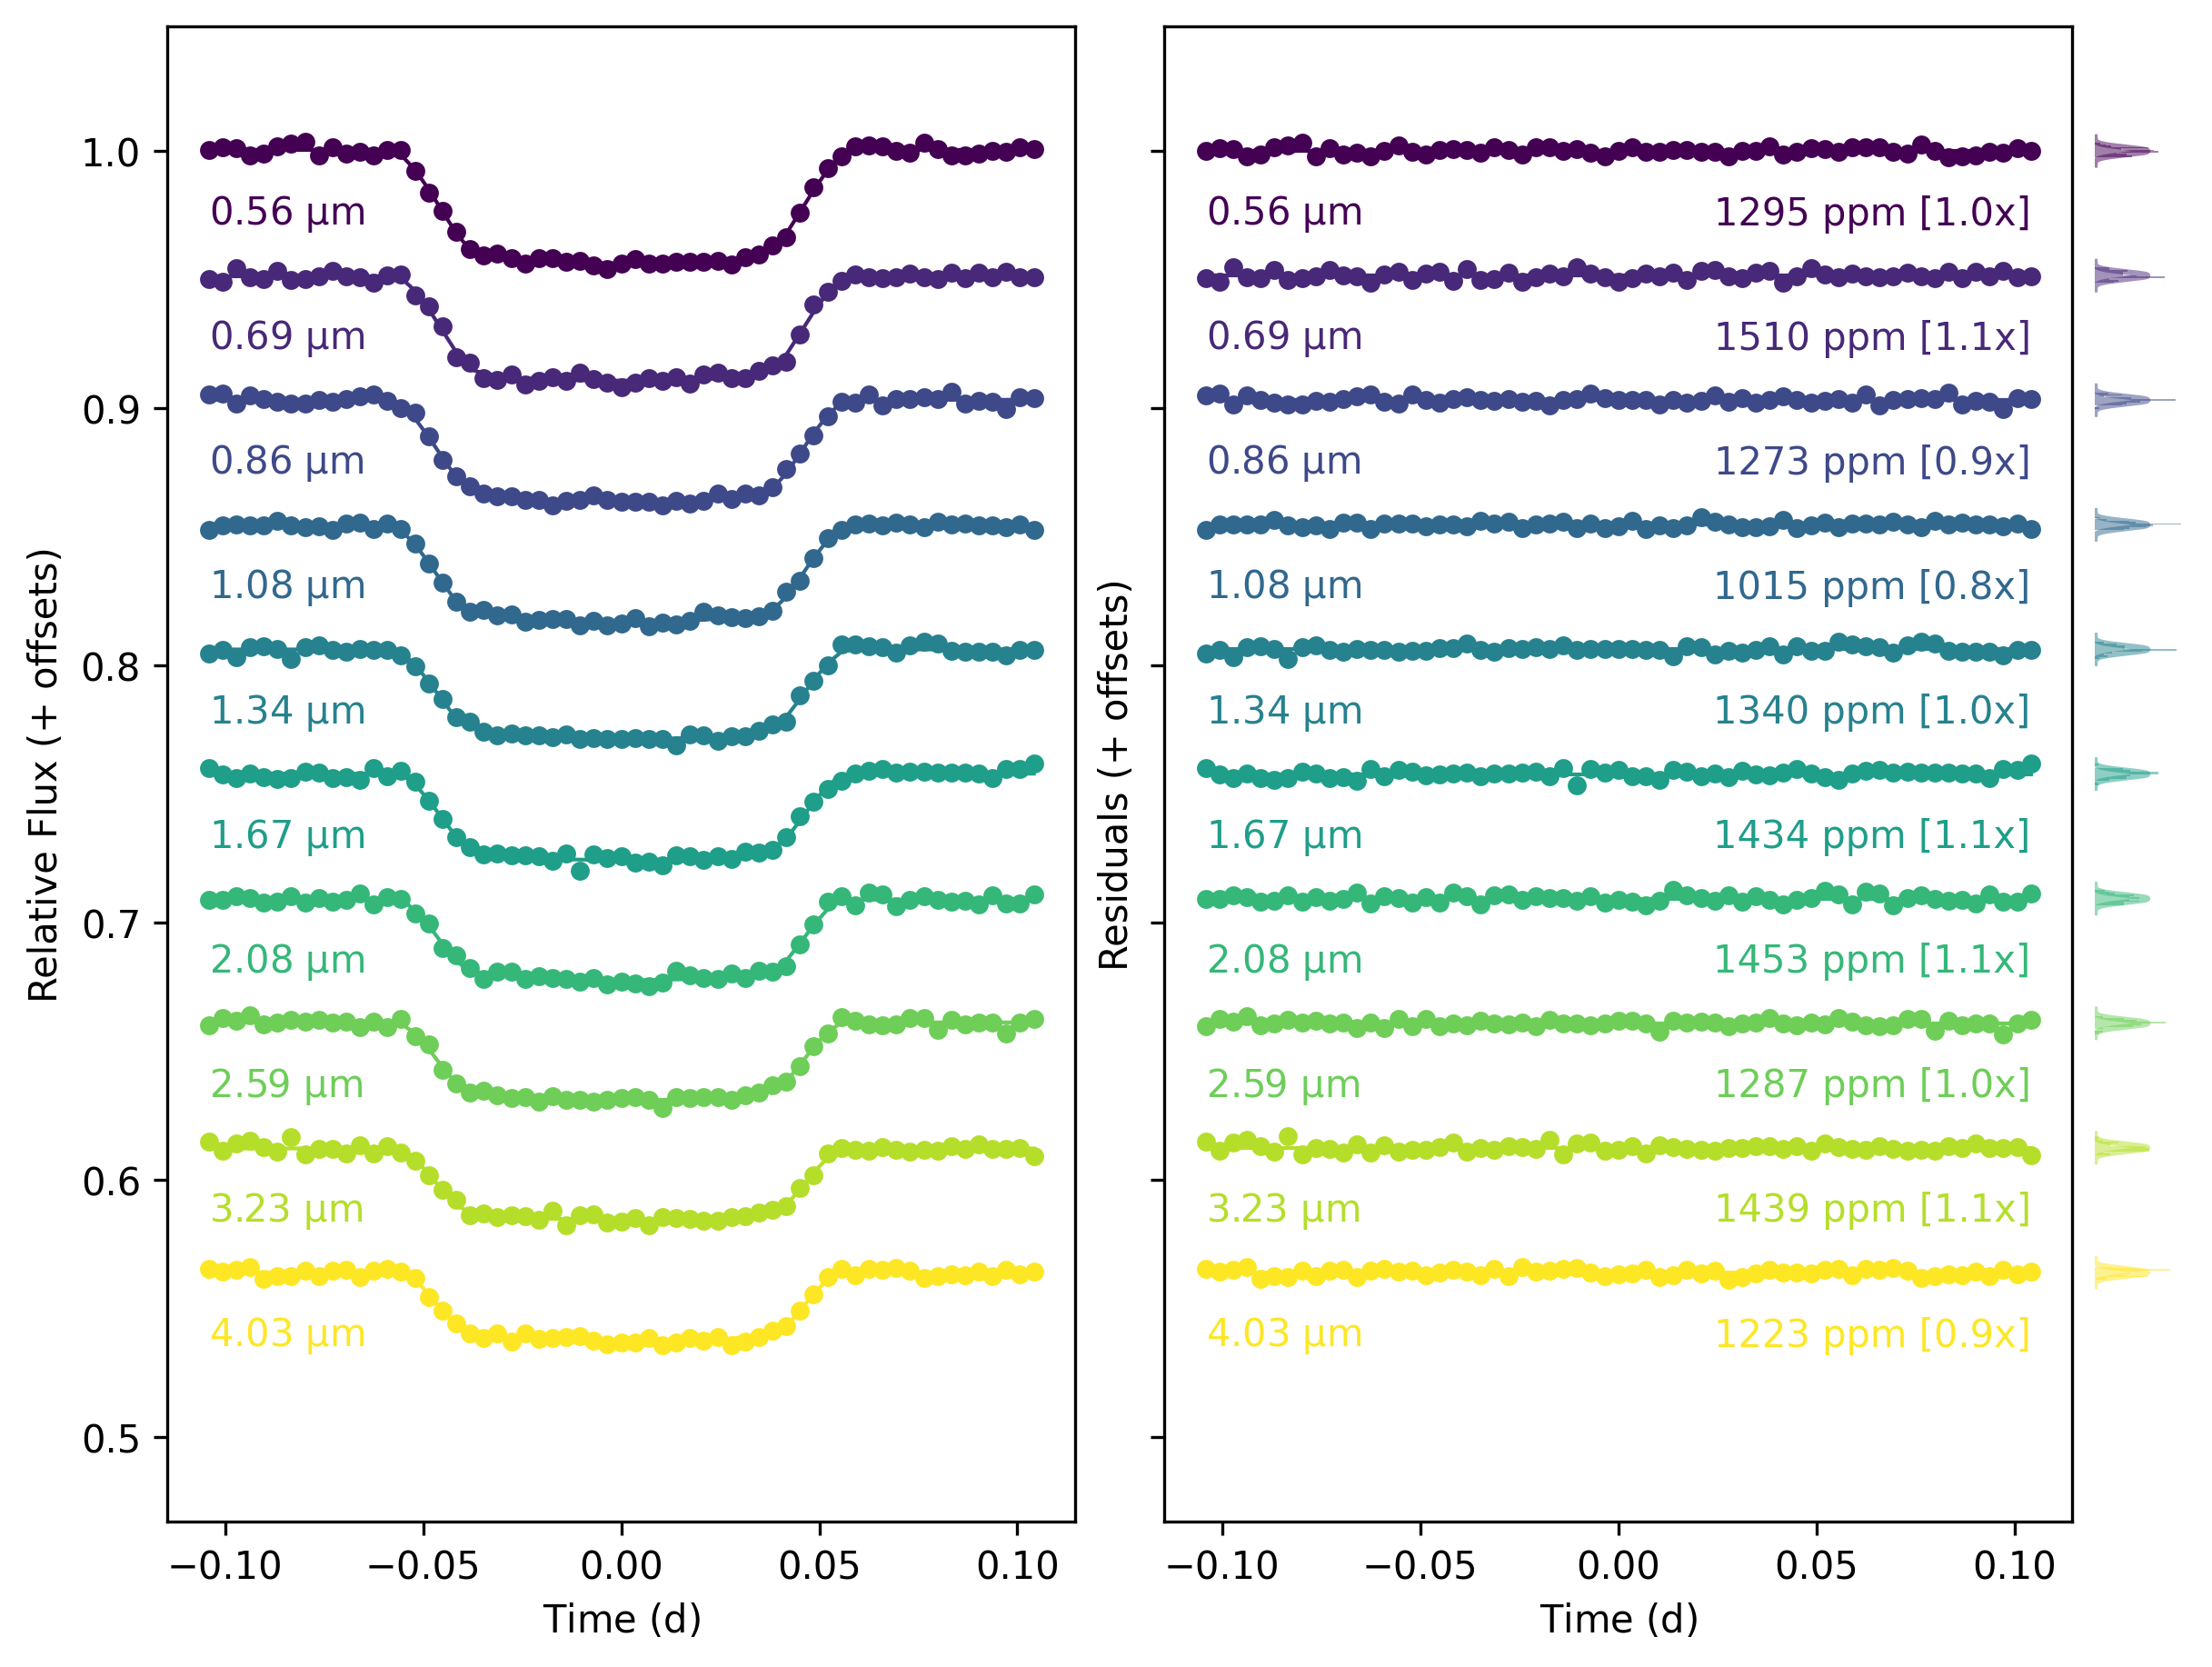

In [31]:
t.plot_with_model_and_residuals()

🌈🤖 'systematics_model' doesn't exist and will be skipped.



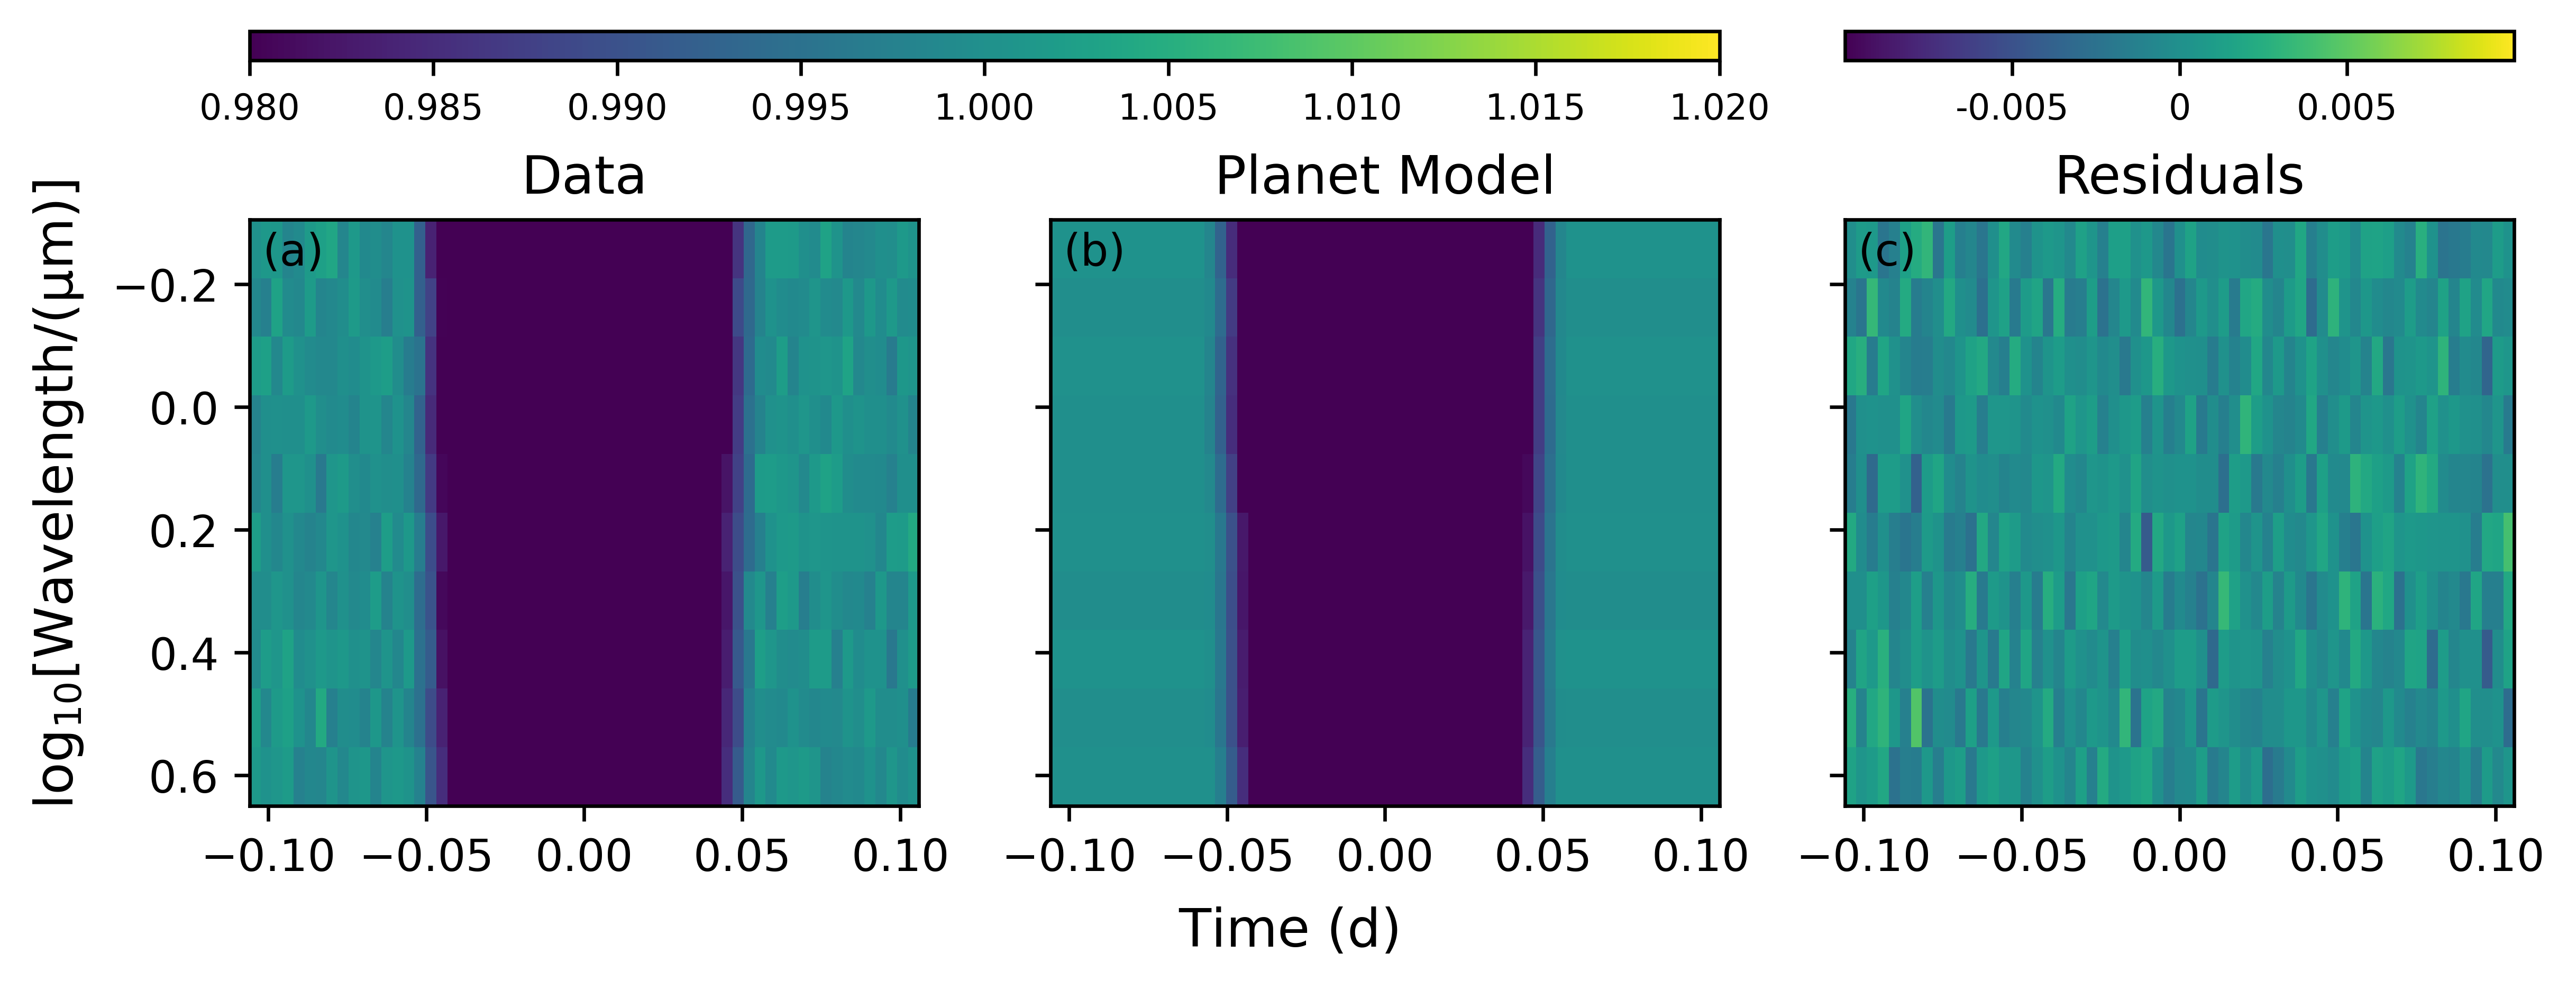

In [32]:
t.imshow_with_models(vspan_residuals=0.01)

## Plot the Transmission Spectrum

We can also plot the transmission spectrum (and we know what the true values are). Here's what we know about the injected transit:

In [33]:
rb.metadata['injected_transit_parameters']

{'rp': array([0.2       , 0.19956522, 0.19913043, 0.19869565, 0.19826087,
        0.19782609, 0.1973913 , 0.19695652, 0.19652174, 0.19608696,
        0.19565217, 0.19521739, 0.19478261, 0.19434783, 0.19391304,
        0.19347826, 0.19304348, 0.1926087 , 0.19217391, 0.19173913,
        0.19130435, 0.19086957, 0.19043478, 0.19      , 0.18956522,
        0.18913043, 0.18869565, 0.18826087, 0.18782609, 0.1873913 ,
        0.18695652, 0.18652174, 0.18608696, 0.18565217, 0.18521739,
        0.18478261, 0.18434783, 0.18391304, 0.18347826, 0.18304348,
        0.1826087 , 0.18217391, 0.18173913, 0.18130435, 0.18086957,
        0.18043478, 0.18      , 0.17956522, 0.17913043, 0.17869565,
        0.17826087, 0.17782609, 0.1773913 , 0.17695652, 0.17652174,
        0.17608696, 0.17565217, 0.17521739, 0.17478261, 0.17434783,
        0.17391304, 0.17347826, 0.17304348, 0.1726087 , 0.17217391,
        0.17173913, 0.17130435, 0.17086957, 0.17043478, 0.17      ,
        0.16956522, 0.16913043, 0.16869565

Plot the transmission spectrum (and in this case we can compare to the original model):

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/transit.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans_table[f"{self.name}_radius_ratio_neg_error"] = (


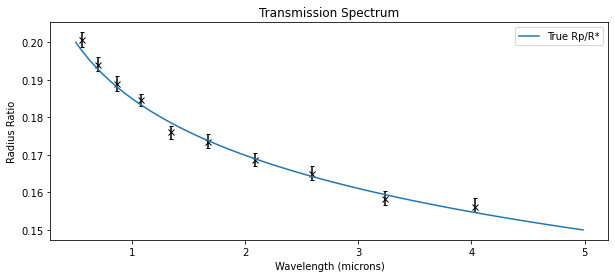

In [34]:
t.plot_transmission_spectrum(uncertainty=['hdi_16%','hdi_84%'])
plt.plot(r.wavelength, rb.metadata['injected_transit_parameters']['rp'], label="True Rp/R*")

plt.legend();

We can also run some diagnostic checks to see the quality of our fit! You might want to check the chi-squared or reduced chi-squared statistic:


For Entire Simultaneous Fit:
Fitted Parameters:
 transit_radius_ratio[0], transit_baseline[0], transit_epoch[0], transit_impact_parameter[0], transit_stellar_radius[0], transit_stellar_mass[0], transit_limb_darkening[0, 0], transit_limb_darkening[0, 1], transit_a_R*[0], transit_planet_radius[0], transit_radius_ratio[1], transit_baseline[1], transit_epoch[1], transit_impact_parameter[1], transit_stellar_radius[1], transit_stellar_mass[1], transit_limb_darkening[1, 0], transit_limb_darkening[1, 1], transit_a_R*[1], transit_planet_radius[1], transit_radius_ratio[2], transit_baseline[2], transit_epoch[2], transit_impact_parameter[2], transit_stellar_radius[2], transit_stellar_mass[2], transit_limb_darkening[2, 0], transit_limb_darkening[2, 1], transit_a_R*[2], transit_planet_radius[2], transit_radius_ratio[3], transit_baseline[3], transit_epoch[3], transit_impact_parameter[3], transit_stellar_radius[3], transit_stellar_mass[3], transit_limb_darkening[3, 0], transit_limb_darkening[3, 1], t

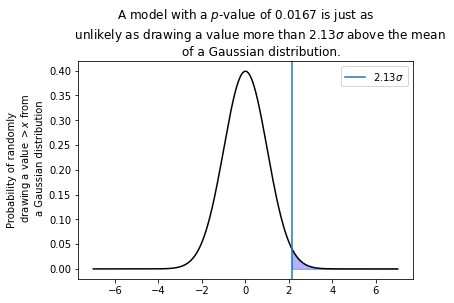

In [35]:
t.chi_squared(plot=True)

Or we can inspect the residual with several different plotting methods:

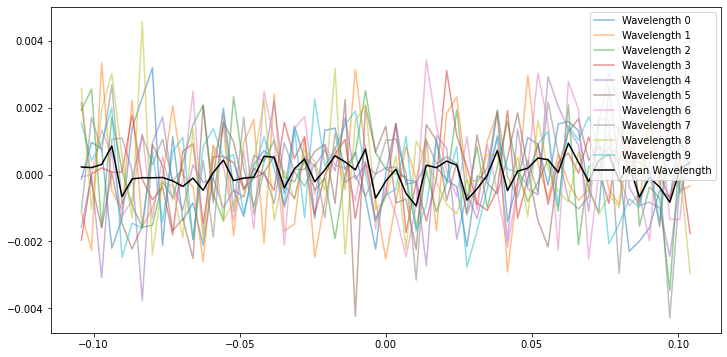

In [36]:
t.plot_residuals()

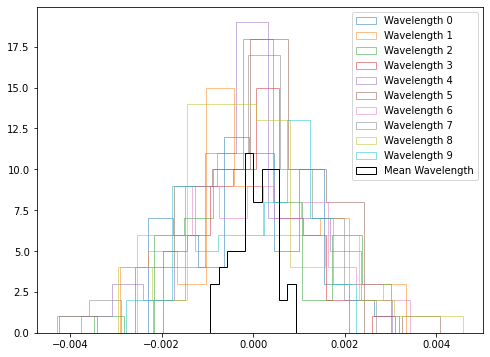

In [37]:
t.plot_residuals_histogram()

For the Wavelength-Averaged Residuals...


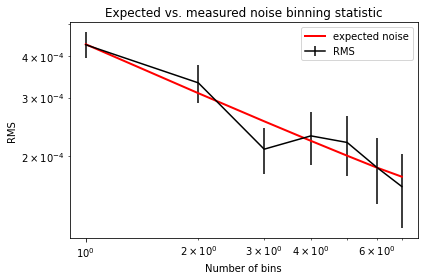

Calculated white noise: 0.00040775 

        Calculated red noise: 0.00014806 

        Calculated beta: 1.5526


In [38]:
t.residual_noise_calculator()

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/diagnostics/statistics.py:71: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogx(1 / freq, power)


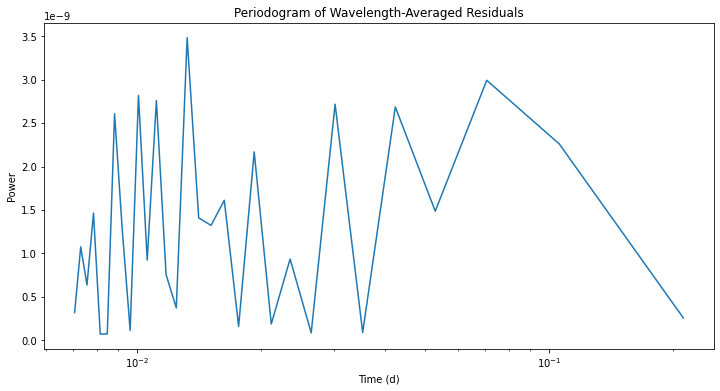

In [39]:
t.plot_residuals_periodogram()